In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from faster_rcnn.utils.datasets.ggimages import OpenImage
from faster_rcnn.utils.datasets.transform import RandomHorizontalFlip, Resize, Compose
import torchvision.transforms as transforms
from faster_rcnn.utils.display.images import imshow, result_show
from torch.utils.data import DataLoader
from faster_rcnn.utils.datasets.adapter import convert_data
import numpy as np
import torch

general_transform = Compose([
    Resize(600),
    RandomHorizontalFlip(0.5)
])


transform = transforms.Compose([
                transforms.RandomChoice([
                    transforms.ColorJitter(hue=.1, saturation=.1),
                    transforms.RandomGrayscale(p=0.7),
                ]),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [
                                     0.229, 0.224, 0.225])
            ])

In [3]:
from pycrayon import CrayonClient

import cPickle
from torch.optim import SGD, RMSprop, Adam
from torch.optim.lr_scheduler import StepLR
from datetime import datetime
from faster_rcnn.utils.datasets.adapter import convert_data
from faster_rcnn.utils.evaluate.metter import AverageMeter
from faster_rcnn.utils.display.images import imshow, result_show

In [4]:
batch_size = 8

ds = OpenImage('/data/data', 'OpenImage', general_transform=general_transform, transform=transform)

train_data_loader = DataLoader(ds, batch_size=batch_size, shuffle=True, collate_fn=convert_data, num_workers=0)


6de28075f20e7d28.jpg [[761.60220994 260.22099448 818.78453039 382.0441989    2.        ]
 [618.2320442   33.97790055 847.79005525 399.44751381   2.        ]]


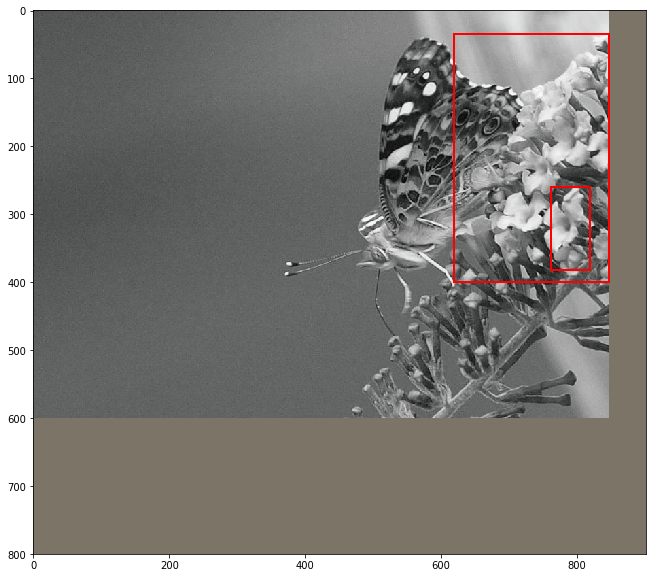

f132c79ab21a6434.jpg [[5.43643693e+02 3.12093628e+01 7.41823147e+02 5.32899870e+02
  1.00000000e+00]
 [1.07492848e+02 1.92717815e+02 7.98000000e+02 5.98439532e+02
  1.00000000e+00]
 [6.00780234e-01 1.17035111e+02 7.98000000e+02 2.09102731e+02
  1.00000000e+00]
 [3.96959688e+02 1.25617685e+02 4.87466840e+02 3.48764629e+02
  1.00000000e+00]
 [3.26738622e+02 2.16905072e+02 3.83695709e+02 2.66059818e+02
  1.00000000e+00]
 [2.22187256e+02 2.50455137e+02 2.69781534e+02 3.23016905e+02
  1.00000000e+00]
 [1.81615085e+02 2.49674902e+02 2.13604681e+02 3.51105332e+02
  1.00000000e+00]
 [6.00780234e-01 3.13654096e+02 1.52746424e+02 4.69700910e+02
  1.00000000e+00]
 [6.00780234e-01 7.02210663e+01 1.34801040e+02 3.73732120e+02
  1.00000000e+00]
 [6.00780234e-01 4.75162549e+02 8.48660598e+01 5.98439532e+02
  1.00000000e+00]]


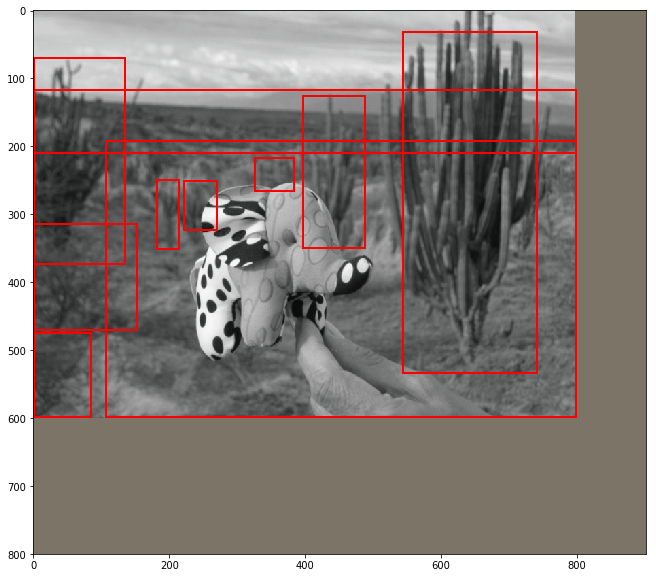

034cf14f87400c10.jpg [[390.625   680.46875 443.75    692.96875   1.     ]]


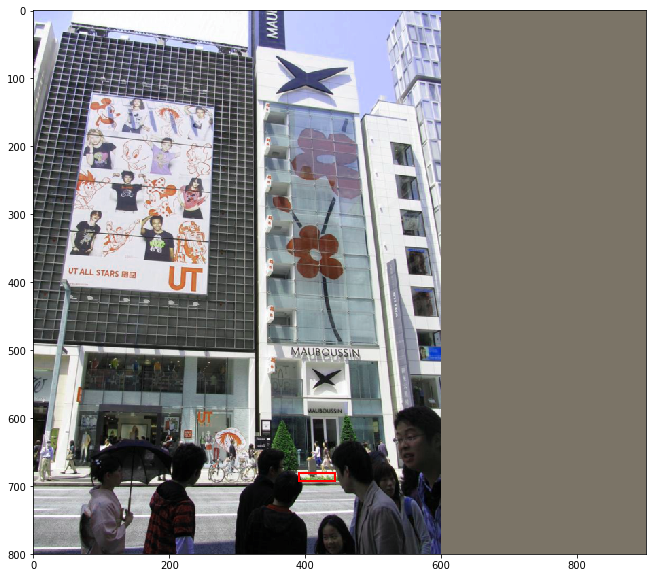

395a946da7be5639.jpg [[157.50660793 244.9339207  873.8061674  600.           2.        ]]


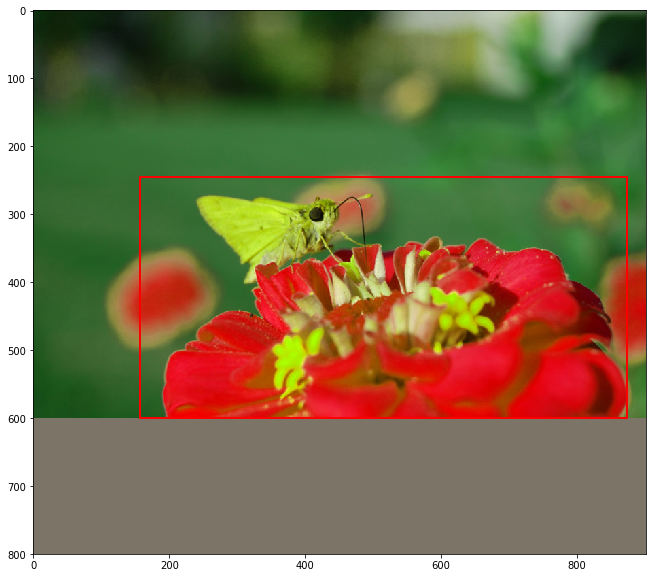

b8235220bbe1861e.jpg [[ 4.44705710e+02  1.00146413e+02  5.48366032e+02  2.02049780e+02
   2.00000000e+00]
 [ 7.75891654e+02  2.21376281e+02  8.72524158e+02  3.03953148e+02
   2.00000000e+00]
 [ 7.92582723e+02  1.66910688e+02  8.38263543e+02  2.22254758e+02
   2.00000000e+00]
 [ 5.79991215e+02  1.30014641e+02  6.46755490e+02  1.80087848e+02
   2.00000000e+00]
 [ 2.54954612e+02  1.29136164e+02  3.09420205e+02  2.04685212e+02
   2.00000000e+00]
 [ 8.18945827e+01  1.37042460e+02  2.09273792e+02  1.92386530e+02
   2.00000000e+00]
 [-6.82284041e-01  1.98535871e+02  1.36360176e+02  3.13616398e+02
   2.00000000e+00]]


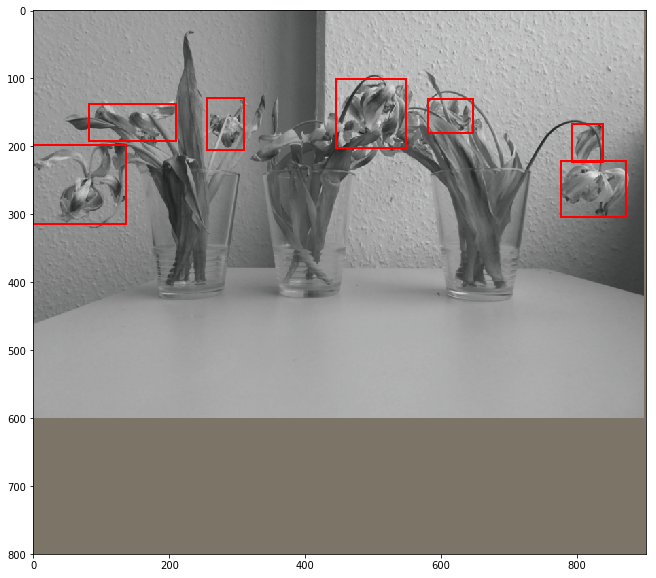

0f2cdaa732447426.jpg [[584.18740849 104.53879941 713.32357247 192.38653001   2.        ]]


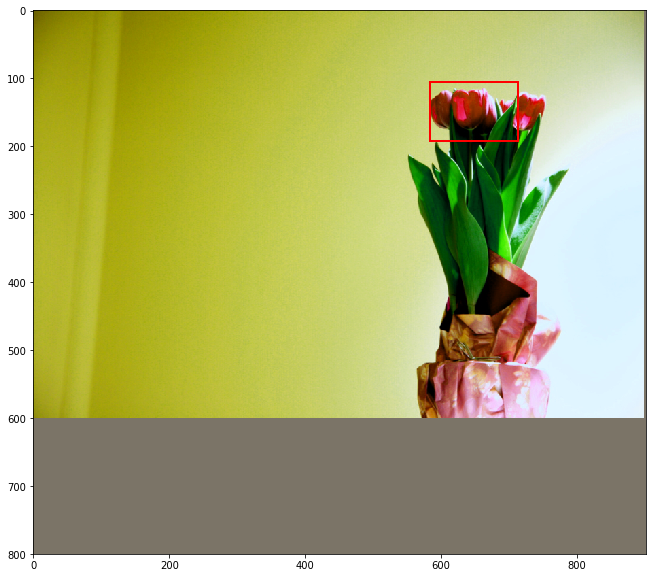

8615d5500b682c42.jpg [[9.9218750e+01 0.0000000e+00 7.0625000e+02 6.0000000e+02 1.0000000e+00]
 [7.0781250e+02 0.0000000e+00 8.0000000e+02 3.3125000e+02 1.0000000e+00]
 [7.8125000e-01 0.0000000e+00 1.0078125e+02 5.4140625e+02 1.0000000e+00]]


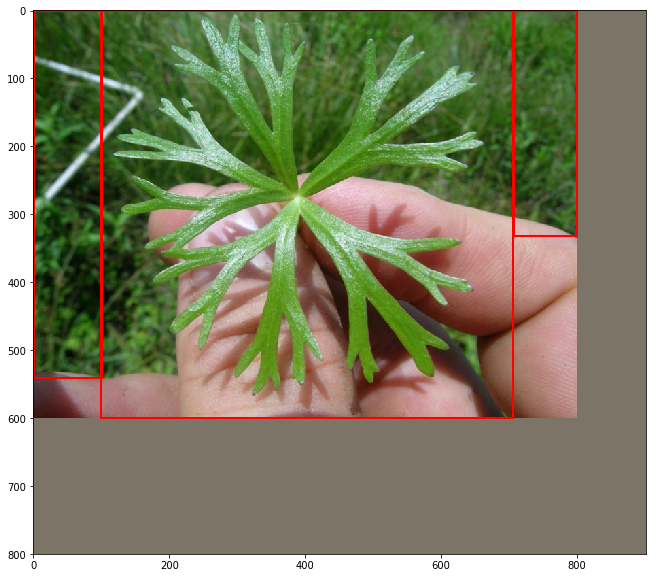

63641fcdae84ff06.jpg [[174.21875  27.34375 497.65625 364.0625    2.     ]]


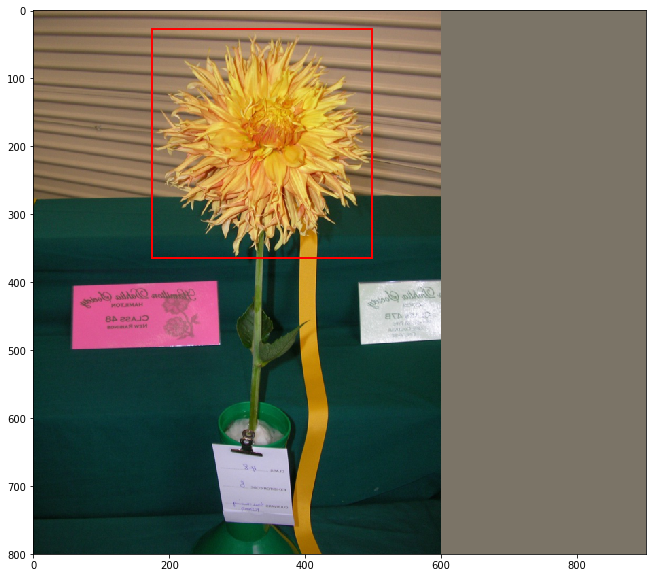

In [5]:
for i, data in enumerate(train_data_loader):
    if not data:
        continue
    if i > 0:
        break
    batch_tensor, im_info, batch_boxes, batch_boxes_index, img_names = data
#     print batch_boxes.shape
    for k in range(batch_tensor.shape[0]):
        print img_names[k], batch_boxes[np.where(batch_boxes_index == k )]
        imshow(batch_tensor[k], gt_boxes=batch_boxes[ np.where(batch_boxes_index == k )])
    del batch_tensor, im_info, batch_boxes, batch_boxes_index   

In [5]:
from faster_rcnn.faster_rcnn import FastRCNN

In [6]:
categories = ds.classes
print(categories)

['__background__', 'Plant', 'Flower']


In [7]:
ds.label_map_dict

{'Flower': 2, 'Plant': 1, '__background__': 0}

In [8]:
net = FastRCNN(categories, debug=False)
net.cuda()
net.train()

/opt/conda/envs/pytorch/lib/python2.7/site-packages/torch/nn/parallel/data_parallel.py:24: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


FastRCNN(
  (rpn): RPN(
    (features): DataParallel(
      (module): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (15): 

In [11]:
param = filter(lambda x: x.requires_grad, net.parameters())
optimizer = RMSprop(param, lr=1e-5, momentum=0.9, weight_decay=0.00005)
exp_lr_scheduler = StepLR(optimizer, step_size=5000, gamma=0.99)

In [12]:
def train(data_gen ,model, tensorboard_client, metters, optimizer, lr_scheduler, current_epoch=0):
    
    steps_per_epoch = len(data_gen) 
    model.train()
    train_loss , cross_entropy , loss_box, rpn_loss = metters
    for step, blobs in enumerate(data_gen):
        try:
            batch_tensor, im_info, batch_boxes, batch_boxes_index, name = blobs
            cls_prob, bbox_pred, rois, cls_score, target, rpn_cls_prob_reshape, rpn_bbox_pred, rpn_target = model(batch_tensor, im_info, batch_boxes, batch_boxes_index)
            rpn_cross_entropy, rpn_bbox_loss = model.rpn.build_loss(rpn_cls_prob_reshape, rpn_bbox_pred, rpn_target)
            cross_entropy, bbox_loss = model.build_loss(cls_score, bbox_pred, target)
            loss = rpn_cross_entropy + rpn_bbox_loss * 10 + cross_entropy + bbox_loss * 10
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

            train_loss.update(loss.item())     

            current_step = current_epoch * steps_per_epoch + step
            if step % 10 == 1:
                log_text = 'epoch: %d : step %d,  loss: %.4f at %s' % (
                    current_epoch + 1, step , train_loss.avg, datetime.now().strftime('%m/%d_%H:%M'))
                print(log_text)

            if step % 100 == 0:
                tensorboard_client.add_scalar_value('train_loss', train_loss.avg, step=current_step)

            del loss, rpn_cross_entropy , rpn_bbox_loss , cross_entropy , bbox_loss, cls_prob, bbox_pred, rois, cls_score, target, rpn_cls_prob_reshape, rpn_bbox_pred, rpn_target
        except Exception as e:
            print(e)
            continue

In [13]:
def training(train_data_gen, optimizer, lr_scheduler ,model, epochs=10):
    
    exp_name = datetime.now().strftime('vgg16_apple_%m-%d_%H-%Ms')
    cc = CrayonClient(hostname="crayon", port=8889)
    exp = cc.create_experiment(exp_name)
    
    
    train_loss = AverageMeter()
    cross_entropy = AverageMeter()
    loss_box = AverageMeter()
    rpn_loss = AverageMeter()
    metters = (train_loss , cross_entropy , loss_box, rpn_loss)

    for epoch in range(epochs):
        train(train_data_gen ,model, exp, metters, optimizer, lr_scheduler, epoch)
        torch.save(net.state_dict(), './checkpoints/faster_model_apple_at_%d.pkl' % epoch) 

In [14]:
training(train_data_loader ,optimizer=optimizer,lr_scheduler=exp_lr_scheduler, model=net, epochs=5)

faster_rcnn/rpn_msr/anchor_target_layer.py:333: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  current_batch_boxes = batch_boxes[[batch_boxes_index == i]]
faster_rcnn/rpn_msr/proposal_target_layer.py:75: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  current_gt_boxes = gt_boxes[[gt_boxes_index == i]]
faster_rcnn/faster_rcnn.py:266: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cls_prob = F.softmax(cls_score)


epoch: 1 : step 1,  loss: 4.7422 at 12/15_05:24
epoch: 1 : step 11,  loss: 2.7699 at 12/15_05:24
epoch: 1 : step 21,  loss: 2.2834 at 12/15_05:24
epoch: 1 : step 31,  loss: 2.1797 at 12/15_05:25
epoch: 1 : step 41,  loss: 2.0727 at 12/15_05:25
epoch: 1 : step 51,  loss: 2.0172 at 12/15_05:25
epoch: 1 : step 61,  loss: 1.9747 at 12/15_05:26
epoch: 1 : step 71,  loss: 1.9170 at 12/15_05:26
epoch: 1 : step 81,  loss: 1.9287 at 12/15_05:27
epoch: 1 : step 91,  loss: 1.9169 at 12/15_05:27
epoch: 1 : step 101,  loss: 1.8933 at 12/15_05:27
epoch: 1 : step 111,  loss: 1.8865 at 12/15_05:28
epoch: 1 : step 121,  loss: 1.8754 at 12/15_05:28
epoch: 1 : step 131,  loss: 1.8491 at 12/15_05:28
epoch: 1 : step 141,  loss: 1.8492 at 12/15_05:29
epoch: 1 : step 151,  loss: 1.8490 at 12/15_05:29
epoch: 1 : step 161,  loss: 1.8346 at 12/15_05:30
epoch: 1 : step 171,  loss: 1.8166 at 12/15_05:30
epoch: 1 : step 181,  loss: 1.8167 at 12/15_05:30
epoch: 1 : step 191,  loss: 1.8176 at 12/15_05:31
epoch: 1 : 

epoch: 1 : step 1631,  loss: 1.7122 at 12/15_06:19
epoch: 1 : step 1641,  loss: 1.7126 at 12/15_06:19
epoch: 1 : step 1651,  loss: 1.7124 at 12/15_06:20
epoch: 1 : step 1661,  loss: 1.7123 at 12/15_06:20
epoch: 1 : step 1671,  loss: 1.7109 at 12/15_06:20
epoch: 1 : step 1681,  loss: 1.7096 at 12/15_06:21
epoch: 1 : step 1691,  loss: 1.7103 at 12/15_06:21
epoch: 1 : step 1701,  loss: 1.7107 at 12/15_06:21
epoch: 1 : step 1711,  loss: 1.7105 at 12/15_06:22
epoch: 1 : step 1721,  loss: 1.7102 at 12/15_06:22
epoch: 1 : step 1731,  loss: 1.7102 at 12/15_06:22
epoch: 1 : step 1741,  loss: 1.7093 at 12/15_06:23
epoch: 1 : step 1751,  loss: 1.7085 at 12/15_06:23
epoch: 1 : step 1761,  loss: 1.7082 at 12/15_06:23
epoch: 1 : step 1771,  loss: 1.7081 at 12/15_06:24
epoch: 1 : step 1781,  loss: 1.7077 at 12/15_06:24
epoch: 1 : step 1791,  loss: 1.7080 at 12/15_06:24
epoch: 1 : step 1801,  loss: 1.7074 at 12/15_06:25
epoch: 1 : step 1811,  loss: 1.7072 at 12/15_06:25
epoch: 1 : step 1821,  loss: 1.

epoch: 1 : step 3241,  loss: 1.7190 at 12/15_07:14
epoch: 1 : step 3251,  loss: 1.7187 at 12/15_07:14
epoch: 1 : step 3261,  loss: 1.7185 at 12/15_07:14
epoch: 1 : step 3271,  loss: 1.7184 at 12/15_07:15
epoch: 1 : step 3281,  loss: 1.7185 at 12/15_07:15
epoch: 1 : step 3291,  loss: 1.7187 at 12/15_07:15
epoch: 1 : step 3301,  loss: 1.7188 at 12/15_07:16
epoch: 1 : step 3311,  loss: 1.7190 at 12/15_07:16
epoch: 1 : step 3321,  loss: 1.7188 at 12/15_07:16
epoch: 1 : step 3331,  loss: 1.7187 at 12/15_07:17
epoch: 1 : step 3341,  loss: 1.7190 at 12/15_07:17
epoch: 1 : step 3351,  loss: 1.7192 at 12/15_07:17
epoch: 1 : step 3361,  loss: 1.7191 at 12/15_07:18
epoch: 1 : step 3371,  loss: 1.7188 at 12/15_07:18
epoch: 1 : step 3381,  loss: 1.7189 at 12/15_07:18
epoch: 1 : step 3391,  loss: 1.7189 at 12/15_07:19
epoch: 1 : step 3401,  loss: 1.7187 at 12/15_07:19
epoch: 1 : step 3411,  loss: 1.7186 at 12/15_07:19
epoch: 1 : step 3421,  loss: 1.7185 at 12/15_07:20
epoch: 1 : step 3431,  loss: 1.

epoch: 1 : step 4851,  loss: 1.7109 at 12/15_08:08
epoch: 1 : step 4861,  loss: 1.7109 at 12/15_08:08
epoch: 1 : step 4871,  loss: 1.7109 at 12/15_08:09
epoch: 1 : step 4881,  loss: 1.7109 at 12/15_08:09
epoch: 1 : step 4891,  loss: 1.7108 at 12/15_08:09
epoch: 1 : step 4901,  loss: 1.7106 at 12/15_08:10
epoch: 1 : step 4911,  loss: 1.7109 at 12/15_08:10
epoch: 1 : step 4921,  loss: 1.7108 at 12/15_08:10
epoch: 1 : step 4931,  loss: 1.7108 at 12/15_08:11
epoch: 1 : step 4941,  loss: 1.7109 at 12/15_08:11
epoch: 1 : step 4951,  loss: 1.7107 at 12/15_08:11
epoch: 1 : step 4961,  loss: 1.7106 at 12/15_08:12
epoch: 1 : step 4971,  loss: 1.7104 at 12/15_08:12
epoch: 1 : step 4981,  loss: 1.7103 at 12/15_08:12
epoch: 1 : step 4991,  loss: 1.7103 at 12/15_08:13
epoch: 1 : step 5001,  loss: 1.7101 at 12/15_08:13
epoch: 1 : step 5011,  loss: 1.7100 at 12/15_08:13
epoch: 1 : step 5021,  loss: 1.7098 at 12/15_08:14
epoch: 1 : step 5031,  loss: 1.7096 at 12/15_08:14
epoch: 1 : step 5041,  loss: 1.

epoch: 1 : step 6461,  loss: 1.6976 at 12/15_09:03
epoch: 1 : step 6471,  loss: 1.6975 at 12/15_09:03
epoch: 1 : step 6481,  loss: 1.6973 at 12/15_09:03
epoch: 1 : step 6491,  loss: 1.6971 at 12/15_09:04
epoch: 1 : step 6501,  loss: 1.6969 at 12/15_09:04
epoch: 1 : step 6511,  loss: 1.6969 at 12/15_09:04
epoch: 1 : step 6521,  loss: 1.6969 at 12/15_09:05
epoch: 1 : step 6531,  loss: 1.6968 at 12/15_09:05
epoch: 1 : step 6541,  loss: 1.6970 at 12/15_09:05
epoch: 1 : step 6551,  loss: 1.6969 at 12/15_09:06
epoch: 1 : step 6561,  loss: 1.6967 at 12/15_09:06
epoch: 1 : step 6571,  loss: 1.6965 at 12/15_09:06
epoch: 1 : step 6581,  loss: 1.6965 at 12/15_09:07
epoch: 1 : step 6591,  loss: 1.6963 at 12/15_09:07
epoch: 1 : step 6601,  loss: 1.6961 at 12/15_09:07
epoch: 1 : step 6611,  loss: 1.6959 at 12/15_09:08
epoch: 1 : step 6621,  loss: 1.6956 at 12/15_09:08
epoch: 1 : step 6631,  loss: 1.6953 at 12/15_09:08
epoch: 1 : step 6641,  loss: 1.6951 at 12/15_09:09
epoch: 1 : step 6651,  loss: 1.

epoch: 1 : step 8071,  loss: 1.6816 at 12/15_09:57
epoch: 1 : step 8081,  loss: 1.6815 at 12/15_09:58
epoch: 1 : step 8091,  loss: 1.6816 at 12/15_09:58
epoch: 1 : step 8101,  loss: 1.6815 at 12/15_09:58
epoch: 1 : step 8111,  loss: 1.6814 at 12/15_09:59
epoch: 1 : step 8121,  loss: 1.6811 at 12/15_09:59
epoch: 1 : step 8131,  loss: 1.6810 at 12/15_09:59
epoch: 1 : step 8141,  loss: 1.6811 at 12/15_10:00
epoch: 1 : step 8151,  loss: 1.6811 at 12/15_10:00
epoch: 1 : step 8161,  loss: 1.6809 at 12/15_10:00
epoch: 1 : step 8171,  loss: 1.6809 at 12/15_10:01
epoch: 1 : step 8181,  loss: 1.6807 at 12/15_10:01
epoch: 1 : step 8191,  loss: 1.6807 at 12/15_10:01
epoch: 1 : step 8201,  loss: 1.6807 at 12/15_10:02
epoch: 1 : step 8211,  loss: 1.6806 at 12/15_10:02
epoch: 1 : step 8221,  loss: 1.6806 at 12/15_10:02
epoch: 1 : step 8231,  loss: 1.6806 at 12/15_10:03
epoch: 1 : step 8241,  loss: 1.6805 at 12/15_10:03
epoch: 1 : step 8251,  loss: 1.6804 at 12/15_10:03
epoch: 1 : step 8261,  loss: 1.

epoch: 1 : step 9681,  loss: 1.6669 at 12/15_10:52
epoch: 1 : step 9691,  loss: 1.6668 at 12/15_10:53
epoch: 1 : step 9701,  loss: 1.6667 at 12/15_10:53
epoch: 1 : step 9711,  loss: 1.6665 at 12/15_10:53
epoch: 1 : step 9721,  loss: 1.6666 at 12/15_10:54
epoch: 1 : step 9731,  loss: 1.6665 at 12/15_10:54
epoch: 1 : step 9741,  loss: 1.6663 at 12/15_10:54
epoch: 1 : step 9751,  loss: 1.6663 at 12/15_10:55
epoch: 1 : step 9761,  loss: 1.6662 at 12/15_10:55
epoch: 1 : step 9771,  loss: 1.6661 at 12/15_10:55
epoch: 1 : step 9781,  loss: 1.6660 at 12/15_10:56
epoch: 1 : step 9791,  loss: 1.6661 at 12/15_10:56
epoch: 1 : step 9801,  loss: 1.6660 at 12/15_10:56
epoch: 1 : step 9811,  loss: 1.6659 at 12/15_10:57
epoch: 1 : step 9821,  loss: 1.6659 at 12/15_10:57
epoch: 1 : step 9831,  loss: 1.6658 at 12/15_10:57
epoch: 1 : step 9841,  loss: 1.6658 at 12/15_10:58
epoch: 1 : step 9851,  loss: 1.6656 at 12/15_10:58
epoch: 1 : step 9861,  loss: 1.6656 at 12/15_10:58
epoch: 1 : step 9871,  loss: 1.

epoch: 1 : step 11271,  loss: 1.6552 at 12/15_11:46
epoch: 1 : step 11281,  loss: 1.6552 at 12/15_11:47
epoch: 1 : step 11291,  loss: 1.6551 at 12/15_11:47
epoch: 1 : step 11301,  loss: 1.6551 at 12/15_11:47
epoch: 1 : step 11311,  loss: 1.6550 at 12/15_11:48
epoch: 1 : step 11321,  loss: 1.6550 at 12/15_11:48
epoch: 1 : step 11331,  loss: 1.6548 at 12/15_11:48
epoch: 1 : step 11341,  loss: 1.6548 at 12/15_11:49
epoch: 1 : step 11351,  loss: 1.6547 at 12/15_11:49
epoch: 1 : step 11361,  loss: 1.6546 at 12/15_11:49
epoch: 1 : step 11371,  loss: 1.6545 at 12/15_11:50
epoch: 1 : step 11381,  loss: 1.6545 at 12/15_11:50
epoch: 1 : step 11391,  loss: 1.6543 at 12/15_11:50
epoch: 1 : step 11401,  loss: 1.6543 at 12/15_11:51
epoch: 1 : step 11411,  loss: 1.6541 at 12/15_11:51
epoch: 1 : step 11421,  loss: 1.6541 at 12/15_11:52
epoch: 1 : step 11431,  loss: 1.6540 at 12/15_11:52
epoch: 1 : step 11441,  loss: 1.6540 at 12/15_11:52
epoch: 1 : step 11451,  loss: 1.6539 at 12/15_11:53
epoch: 1 : s

epoch: 1 : step 12851,  loss: 1.6434 at 12/15_12:40
epoch: 1 : step 12861,  loss: 1.6432 at 12/15_12:40
epoch: 1 : step 12871,  loss: 1.6433 at 12/15_12:41
epoch: 1 : step 12881,  loss: 1.6432 at 12/15_12:41
epoch: 1 : step 12891,  loss: 1.6432 at 12/15_12:41
epoch: 1 : step 12901,  loss: 1.6431 at 12/15_12:42
epoch: 1 : step 12911,  loss: 1.6430 at 12/15_12:42
epoch: 1 : step 12921,  loss: 1.6429 at 12/15_12:42
epoch: 1 : step 12931,  loss: 1.6429 at 12/15_12:43
epoch: 1 : step 12941,  loss: 1.6429 at 12/15_12:43
epoch: 1 : step 12951,  loss: 1.6428 at 12/15_12:43
epoch: 1 : step 12961,  loss: 1.6428 at 12/15_12:44
epoch: 1 : step 12971,  loss: 1.6427 at 12/15_12:44
epoch: 1 : step 12981,  loss: 1.6426 at 12/15_12:45
epoch: 1 : step 12991,  loss: 1.6425 at 12/15_12:45
epoch: 1 : step 13001,  loss: 1.6425 at 12/15_12:45
epoch: 1 : step 13011,  loss: 1.6424 at 12/15_12:46
epoch: 1 : step 13021,  loss: 1.6424 at 12/15_12:46
epoch: 1 : step 13031,  loss: 1.6423 at 12/15_12:46
epoch: 1 : s

epoch: 1 : step 14431,  loss: 1.6337 at 12/15_13:34
epoch: 1 : step 14441,  loss: 1.6336 at 12/15_13:35
epoch: 1 : step 14451,  loss: 1.6336 at 12/15_13:35
epoch: 1 : step 14461,  loss: 1.6335 at 12/15_13:35
epoch: 1 : step 14471,  loss: 1.6335 at 12/15_13:36
epoch: 1 : step 14481,  loss: 1.6335 at 12/15_13:36
epoch: 1 : step 14491,  loss: 1.6334 at 12/15_13:36
epoch: 1 : step 14501,  loss: 1.6334 at 12/15_13:37
epoch: 1 : step 14511,  loss: 1.6333 at 12/15_13:37
epoch: 1 : step 14521,  loss: 1.6332 at 12/15_13:37
epoch: 1 : step 14531,  loss: 1.6331 at 12/15_13:38
epoch: 1 : step 14541,  loss: 1.6330 at 12/15_13:38
epoch: 1 : step 14551,  loss: 1.6329 at 12/15_13:38
epoch: 1 : step 14561,  loss: 1.6328 at 12/15_13:39
epoch: 1 : step 14571,  loss: 1.6328 at 12/15_13:39
epoch: 1 : step 14581,  loss: 1.6328 at 12/15_13:39
epoch: 1 : step 14591,  loss: 1.6328 at 12/15_13:40
epoch: 1 : step 14601,  loss: 1.6328 at 12/15_13:40
epoch: 1 : step 14611,  loss: 1.6328 at 12/15_13:40
epoch: 1 : s

epoch: 1 : step 16011,  loss: 1.6238 at 12/15_14:28
epoch: 1 : step 16021,  loss: 1.6236 at 12/15_14:29
epoch: 1 : step 16031,  loss: 1.6235 at 12/15_14:29
epoch: 1 : step 16041,  loss: 1.6234 at 12/15_14:29
epoch: 1 : step 16051,  loss: 1.6234 at 12/15_14:30
epoch: 1 : step 16061,  loss: 1.6233 at 12/15_14:30
epoch: 1 : step 16071,  loss: 1.6233 at 12/15_14:30
epoch: 1 : step 16081,  loss: 1.6232 at 12/15_14:31
epoch: 1 : step 16091,  loss: 1.6232 at 12/15_14:31
epoch: 1 : step 16101,  loss: 1.6232 at 12/15_14:31
epoch: 1 : step 16111,  loss: 1.6231 at 12/15_14:32
epoch: 1 : step 16121,  loss: 1.6230 at 12/15_14:32
epoch: 1 : step 16131,  loss: 1.6229 at 12/15_14:33
epoch: 1 : step 16141,  loss: 1.6227 at 12/15_14:33
epoch: 1 : step 16151,  loss: 1.6226 at 12/15_14:33
epoch: 1 : step 16161,  loss: 1.6225 at 12/15_14:34
epoch: 1 : step 16171,  loss: 1.6224 at 12/15_14:34
epoch: 1 : step 16181,  loss: 1.6223 at 12/15_14:34
epoch: 1 : step 16191,  loss: 1.6223 at 12/15_14:35
epoch: 1 : s

epoch: 2 : step 731,  loss: 1.6140 at 12/15_15:23
epoch: 2 : step 741,  loss: 1.6139 at 12/15_15:24
epoch: 2 : step 751,  loss: 1.6139 at 12/15_15:24
epoch: 2 : step 761,  loss: 1.6138 at 12/15_15:24
epoch: 2 : step 771,  loss: 1.6137 at 12/15_15:25
epoch: 2 : step 781,  loss: 1.6137 at 12/15_15:25
epoch: 2 : step 791,  loss: 1.6136 at 12/15_15:25
epoch: 2 : step 801,  loss: 1.6135 at 12/15_15:26
epoch: 2 : step 811,  loss: 1.6134 at 12/15_15:26
epoch: 2 : step 821,  loss: 1.6134 at 12/15_15:26
epoch: 2 : step 831,  loss: 1.6134 at 12/15_15:27
epoch: 2 : step 841,  loss: 1.6133 at 12/15_15:27
epoch: 2 : step 851,  loss: 1.6132 at 12/15_15:27
epoch: 2 : step 861,  loss: 1.6132 at 12/15_15:28
epoch: 2 : step 871,  loss: 1.6132 at 12/15_15:28
epoch: 2 : step 881,  loss: 1.6131 at 12/15_15:28
epoch: 2 : step 891,  loss: 1.6131 at 12/15_15:29
epoch: 2 : step 901,  loss: 1.6131 at 12/15_15:29
epoch: 2 : step 911,  loss: 1.6131 at 12/15_15:29
epoch: 2 : step 921,  loss: 1.6130 at 12/15_15:30


epoch: 2 : step 2351,  loss: 1.6058 at 12/15_16:18
epoch: 2 : step 2361,  loss: 1.6058 at 12/15_16:19
epoch: 2 : step 2371,  loss: 1.6057 at 12/15_16:19
epoch: 2 : step 2381,  loss: 1.6056 at 12/15_16:19
epoch: 2 : step 2391,  loss: 1.6056 at 12/15_16:20
epoch: 2 : step 2401,  loss: 1.6055 at 12/15_16:20
epoch: 2 : step 2411,  loss: 1.6055 at 12/15_16:20
epoch: 2 : step 2421,  loss: 1.6055 at 12/15_16:21
epoch: 2 : step 2431,  loss: 1.6055 at 12/15_16:21
epoch: 2 : step 2441,  loss: 1.6054 at 12/15_16:21
epoch: 2 : step 2451,  loss: 1.6054 at 12/15_16:22
epoch: 2 : step 2461,  loss: 1.6053 at 12/15_16:22
epoch: 2 : step 2471,  loss: 1.6053 at 12/15_16:22
epoch: 2 : step 2481,  loss: 1.6052 at 12/15_16:23
epoch: 2 : step 2491,  loss: 1.6052 at 12/15_16:23
epoch: 2 : step 2501,  loss: 1.6052 at 12/15_16:23
epoch: 2 : step 2511,  loss: 1.6051 at 12/15_16:24
epoch: 2 : step 2521,  loss: 1.6051 at 12/15_16:24
epoch: 2 : step 2531,  loss: 1.6050 at 12/15_16:24
epoch: 2 : step 2541,  loss: 1.

epoch: 2 : step 3961,  loss: 1.5989 at 12/15_17:13
epoch: 2 : step 3971,  loss: 1.5988 at 12/15_17:13
epoch: 2 : step 3981,  loss: 1.5988 at 12/15_17:14
epoch: 2 : step 3991,  loss: 1.5988 at 12/15_17:14
epoch: 2 : step 4001,  loss: 1.5987 at 12/15_17:14
epoch: 2 : step 4011,  loss: 1.5987 at 12/15_17:15
epoch: 2 : step 4021,  loss: 1.5986 at 12/15_17:15
epoch: 2 : step 4031,  loss: 1.5986 at 12/15_17:15
epoch: 2 : step 4041,  loss: 1.5985 at 12/15_17:16
epoch: 2 : step 4051,  loss: 1.5984 at 12/15_17:16
epoch: 2 : step 4061,  loss: 1.5984 at 12/15_17:16
epoch: 2 : step 4071,  loss: 1.5984 at 12/15_17:17
epoch: 2 : step 4081,  loss: 1.5984 at 12/15_17:17
epoch: 2 : step 4091,  loss: 1.5984 at 12/15_17:17
epoch: 2 : step 4101,  loss: 1.5983 at 12/15_17:18
epoch: 2 : step 4111,  loss: 1.5983 at 12/15_17:18
epoch: 2 : step 4121,  loss: 1.5982 at 12/15_17:18
epoch: 2 : step 4131,  loss: 1.5982 at 12/15_17:19
epoch: 2 : step 4141,  loss: 1.5982 at 12/15_17:19
epoch: 2 : step 4151,  loss: 1.

epoch: 2 : step 5571,  loss: 1.5933 at 12/15_18:08
epoch: 2 : step 5581,  loss: 1.5933 at 12/15_18:08
epoch: 2 : step 5591,  loss: 1.5932 at 12/15_18:08
epoch: 2 : step 5601,  loss: 1.5932 at 12/15_18:09
epoch: 2 : step 5611,  loss: 1.5931 at 12/15_18:09
epoch: 2 : step 5621,  loss: 1.5930 at 12/15_18:09
epoch: 2 : step 5631,  loss: 1.5930 at 12/15_18:10
epoch: 2 : step 5641,  loss: 1.5929 at 12/15_18:10
epoch: 2 : step 5651,  loss: 1.5929 at 12/15_18:10
epoch: 2 : step 5661,  loss: 1.5928 at 12/15_18:11
epoch: 2 : step 5671,  loss: 1.5928 at 12/15_18:11
epoch: 2 : step 5681,  loss: 1.5927 at 12/15_18:11
epoch: 2 : step 5691,  loss: 1.5927 at 12/15_18:12
epoch: 2 : step 5701,  loss: 1.5927 at 12/15_18:12
epoch: 2 : step 5711,  loss: 1.5927 at 12/15_18:12
epoch: 2 : step 5721,  loss: 1.5926 at 12/15_18:13
epoch: 2 : step 5731,  loss: 1.5926 at 12/15_18:13
epoch: 2 : step 5741,  loss: 1.5925 at 12/15_18:13
epoch: 2 : step 5751,  loss: 1.5924 at 12/15_18:14
epoch: 2 : step 5761,  loss: 1.

epoch: 2 : step 7181,  loss: 1.5873 at 12/15_19:02
epoch: 2 : step 7191,  loss: 1.5872 at 12/15_19:03
epoch: 2 : step 7201,  loss: 1.5872 at 12/15_19:03
epoch: 2 : step 7211,  loss: 1.5872 at 12/15_19:03
epoch: 2 : step 7221,  loss: 1.5871 at 12/15_19:04
epoch: 2 : step 7231,  loss: 1.5871 at 12/15_19:04
epoch: 2 : step 7241,  loss: 1.5871 at 12/15_19:04
epoch: 2 : step 7251,  loss: 1.5871 at 12/15_19:05
epoch: 2 : step 7261,  loss: 1.5870 at 12/15_19:05
epoch: 2 : step 7271,  loss: 1.5870 at 12/15_19:05
epoch: 2 : step 7281,  loss: 1.5870 at 12/15_19:06
epoch: 2 : step 7291,  loss: 1.5870 at 12/15_19:06
epoch: 2 : step 7301,  loss: 1.5870 at 12/15_19:06
epoch: 2 : step 7311,  loss: 1.5870 at 12/15_19:07
epoch: 2 : step 7321,  loss: 1.5869 at 12/15_19:07
epoch: 2 : step 7331,  loss: 1.5869 at 12/15_19:07
epoch: 2 : step 7341,  loss: 1.5869 at 12/15_19:08
epoch: 2 : step 7351,  loss: 1.5868 at 12/15_19:08
epoch: 2 : step 7361,  loss: 1.5869 at 12/15_19:08
epoch: 2 : step 7371,  loss: 1.

epoch: 2 : step 8791,  loss: 1.5828 at 12/15_19:57
epoch: 2 : step 8801,  loss: 1.5828 at 12/15_19:57
epoch: 2 : step 8811,  loss: 1.5828 at 12/15_19:58
epoch: 2 : step 8821,  loss: 1.5828 at 12/15_19:58
epoch: 2 : step 8831,  loss: 1.5828 at 12/15_19:58
epoch: 2 : step 8841,  loss: 1.5827 at 12/15_19:59
epoch: 2 : step 8851,  loss: 1.5827 at 12/15_19:59
epoch: 2 : step 8861,  loss: 1.5827 at 12/15_19:59
epoch: 2 : step 8871,  loss: 1.5827 at 12/15_20:00
epoch: 2 : step 8881,  loss: 1.5826 at 12/15_20:00
epoch: 2 : step 8891,  loss: 1.5825 at 12/15_20:00
epoch: 2 : step 8901,  loss: 1.5825 at 12/15_20:01
epoch: 2 : step 8911,  loss: 1.5825 at 12/15_20:01
epoch: 2 : step 8921,  loss: 1.5824 at 12/15_20:01
epoch: 2 : step 8931,  loss: 1.5824 at 12/15_20:02
epoch: 2 : step 8941,  loss: 1.5823 at 12/15_20:02
epoch: 2 : step 8951,  loss: 1.5822 at 12/15_20:02
epoch: 2 : step 8961,  loss: 1.5822 at 12/15_20:03
epoch: 2 : step 8971,  loss: 1.5822 at 12/15_20:03
epoch: 2 : step 8981,  loss: 1.

epoch: 2 : step 10391,  loss: 1.5786 at 12/15_20:51
epoch: 2 : step 10401,  loss: 1.5786 at 12/15_20:52
epoch: 2 : step 10411,  loss: 1.5785 at 12/15_20:52
epoch: 2 : step 10421,  loss: 1.5785 at 12/15_20:52
epoch: 2 : step 10431,  loss: 1.5785 at 12/15_20:53
epoch: 2 : step 10441,  loss: 1.5785 at 12/15_20:53
epoch: 2 : step 10451,  loss: 1.5784 at 12/15_20:53
epoch: 2 : step 10461,  loss: 1.5784 at 12/15_20:54
epoch: 2 : step 10471,  loss: 1.5784 at 12/15_20:54
epoch: 2 : step 10481,  loss: 1.5784 at 12/15_20:54
epoch: 2 : step 10491,  loss: 1.5784 at 12/15_20:55
epoch: 2 : step 10501,  loss: 1.5783 at 12/15_20:55
epoch: 2 : step 10511,  loss: 1.5783 at 12/15_20:55
epoch: 2 : step 10521,  loss: 1.5783 at 12/15_20:56
epoch: 2 : step 10531,  loss: 1.5783 at 12/15_20:56
epoch: 2 : step 10541,  loss: 1.5782 at 12/15_20:56
epoch: 2 : step 10551,  loss: 1.5782 at 12/15_20:57
epoch: 2 : step 10561,  loss: 1.5782 at 12/15_20:57
epoch: 2 : step 10571,  loss: 1.5781 at 12/15_20:58
epoch: 2 : s

epoch: 2 : step 11971,  loss: 1.5751 at 12/15_21:45
epoch: 2 : step 11981,  loss: 1.5751 at 12/15_21:45
epoch: 2 : step 11991,  loss: 1.5751 at 12/15_21:45
epoch: 2 : step 12001,  loss: 1.5751 at 12/15_21:46
epoch: 2 : step 12011,  loss: 1.5750 at 12/15_21:46
epoch: 2 : step 12021,  loss: 1.5750 at 12/15_21:46
epoch: 2 : step 12031,  loss: 1.5750 at 12/15_21:47
epoch: 2 : step 12041,  loss: 1.5750 at 12/15_21:47
epoch: 2 : step 12051,  loss: 1.5750 at 12/15_21:47
epoch: 2 : step 12061,  loss: 1.5749 at 12/15_21:48
epoch: 2 : step 12071,  loss: 1.5749 at 12/15_21:48
epoch: 2 : step 12081,  loss: 1.5749 at 12/15_21:48
epoch: 2 : step 12091,  loss: 1.5749 at 12/15_21:49
epoch: 2 : step 12101,  loss: 1.5748 at 12/15_21:49
epoch: 2 : step 12111,  loss: 1.5749 at 12/15_21:49
epoch: 2 : step 12121,  loss: 1.5749 at 12/15_21:50
epoch: 2 : step 12131,  loss: 1.5749 at 12/15_21:50
epoch: 2 : step 12141,  loss: 1.5749 at 12/15_21:50
epoch: 2 : step 12151,  loss: 1.5749 at 12/15_21:51
epoch: 2 : s

epoch: 2 : step 13551,  loss: 1.5713 at 12/15_22:38
epoch: 2 : step 13561,  loss: 1.5713 at 12/15_22:39
epoch: 2 : step 13571,  loss: 1.5712 at 12/15_22:39
epoch: 2 : step 13581,  loss: 1.5712 at 12/15_22:39
epoch: 2 : step 13591,  loss: 1.5712 at 12/15_22:40
epoch: 2 : step 13601,  loss: 1.5711 at 12/15_22:40
epoch: 2 : step 13611,  loss: 1.5711 at 12/15_22:40
epoch: 2 : step 13621,  loss: 1.5711 at 12/15_22:41
epoch: 2 : step 13631,  loss: 1.5710 at 12/15_22:41
epoch: 2 : step 13641,  loss: 1.5710 at 12/15_22:41
epoch: 2 : step 13651,  loss: 1.5709 at 12/15_22:42
epoch: 2 : step 13661,  loss: 1.5709 at 12/15_22:42
epoch: 2 : step 13671,  loss: 1.5709 at 12/15_22:42
epoch: 2 : step 13681,  loss: 1.5708 at 12/15_22:43
epoch: 2 : step 13691,  loss: 1.5708 at 12/15_22:43
epoch: 2 : step 13701,  loss: 1.5708 at 12/15_22:43
epoch: 2 : step 13711,  loss: 1.5708 at 12/15_22:44
epoch: 2 : step 13721,  loss: 1.5708 at 12/15_22:44
epoch: 2 : step 13731,  loss: 1.5707 at 12/15_22:45
epoch: 2 : s

epoch: 2 : step 15131,  loss: 1.5677 at 12/15_23:32
epoch: 2 : step 15141,  loss: 1.5676 at 12/15_23:32
epoch: 2 : step 15151,  loss: 1.5676 at 12/15_23:33
epoch: 2 : step 15161,  loss: 1.5676 at 12/15_23:33
epoch: 2 : step 15171,  loss: 1.5676 at 12/15_23:33
epoch: 2 : step 15181,  loss: 1.5676 at 12/15_23:34
epoch: 2 : step 15191,  loss: 1.5676 at 12/15_23:34
epoch: 2 : step 15201,  loss: 1.5676 at 12/15_23:34
epoch: 2 : step 15211,  loss: 1.5675 at 12/15_23:35
epoch: 2 : step 15221,  loss: 1.5675 at 12/15_23:35
epoch: 2 : step 15231,  loss: 1.5675 at 12/15_23:35
epoch: 2 : step 15241,  loss: 1.5675 at 12/15_23:36
epoch: 2 : step 15251,  loss: 1.5675 at 12/15_23:36
epoch: 2 : step 15261,  loss: 1.5675 at 12/15_23:36
epoch: 2 : step 15271,  loss: 1.5675 at 12/15_23:37
epoch: 2 : step 15281,  loss: 1.5674 at 12/15_23:37
epoch: 2 : step 15291,  loss: 1.5674 at 12/15_23:37
epoch: 2 : step 15301,  loss: 1.5674 at 12/15_23:38
epoch: 2 : step 15311,  loss: 1.5673 at 12/15_23:38
epoch: 2 : s

epoch: 2 : step 16711,  loss: 1.5648 at 12/16_00:26
epoch: 2 : step 16721,  loss: 1.5648 at 12/16_00:26
epoch: 2 : step 16731,  loss: 1.5647 at 12/16_00:26
epoch: 2 : step 16741,  loss: 1.5647 at 12/16_00:27
epoch: 2 : step 16751,  loss: 1.5647 at 12/16_00:27
epoch: 2 : step 16761,  loss: 1.5646 at 12/16_00:27
epoch: 2 : step 16771,  loss: 1.5646 at 12/16_00:28
epoch: 2 : step 16781,  loss: 1.5646 at 12/16_00:28
epoch: 2 : step 16791,  loss: 1.5646 at 12/16_00:28
epoch: 2 : step 16801,  loss: 1.5645 at 12/16_00:29
epoch: 2 : step 16811,  loss: 1.5645 at 12/16_00:29
epoch: 2 : step 16821,  loss: 1.5645 at 12/16_00:29
epoch: 2 : step 16831,  loss: 1.5645 at 12/16_00:30
epoch: 2 : step 16841,  loss: 1.5645 at 12/16_00:30
epoch: 2 : step 16851,  loss: 1.5644 at 12/16_00:30
epoch: 2 : step 16861,  loss: 1.5644 at 12/16_00:31
epoch: 2 : step 16871,  loss: 1.5644 at 12/16_00:31
epoch: 2 : step 16881,  loss: 1.5644 at 12/16_00:31
epoch: 3 : step 1,  loss: 1.5644 at 12/16_00:32
epoch: 3 : step 

epoch: 3 : step 1451,  loss: 1.5615 at 12/16_01:21
epoch: 3 : step 1461,  loss: 1.5615 at 12/16_01:21
epoch: 3 : step 1471,  loss: 1.5615 at 12/16_01:21
epoch: 3 : step 1481,  loss: 1.5615 at 12/16_01:22
epoch: 3 : step 1491,  loss: 1.5615 at 12/16_01:22
epoch: 3 : step 1501,  loss: 1.5615 at 12/16_01:22
epoch: 3 : step 1511,  loss: 1.5615 at 12/16_01:23
epoch: 3 : step 1521,  loss: 1.5615 at 12/16_01:23
epoch: 3 : step 1531,  loss: 1.5615 at 12/16_01:23
epoch: 3 : step 1541,  loss: 1.5615 at 12/16_01:24
epoch: 3 : step 1551,  loss: 1.5614 at 12/16_01:24
epoch: 3 : step 1561,  loss: 1.5614 at 12/16_01:24
epoch: 3 : step 1571,  loss: 1.5614 at 12/16_01:25
epoch: 3 : step 1581,  loss: 1.5613 at 12/16_01:25
epoch: 3 : step 1591,  loss: 1.5613 at 12/16_01:25
epoch: 3 : step 1601,  loss: 1.5613 at 12/16_01:26
epoch: 3 : step 1611,  loss: 1.5613 at 12/16_01:26
epoch: 3 : step 1621,  loss: 1.5613 at 12/16_01:26
epoch: 3 : step 1631,  loss: 1.5613 at 12/16_01:27
epoch: 3 : step 1641,  loss: 1.

epoch: 3 : step 3061,  loss: 1.5590 at 12/16_02:15
epoch: 3 : step 3071,  loss: 1.5589 at 12/16_02:16
epoch: 3 : step 3081,  loss: 1.5589 at 12/16_02:16
epoch: 3 : step 3091,  loss: 1.5589 at 12/16_02:16
epoch: 3 : step 3101,  loss: 1.5589 at 12/16_02:17
epoch: 3 : step 3111,  loss: 1.5589 at 12/16_02:17
epoch: 3 : step 3121,  loss: 1.5589 at 12/16_02:17
epoch: 3 : step 3131,  loss: 1.5589 at 12/16_02:18
epoch: 3 : step 3141,  loss: 1.5589 at 12/16_02:18
epoch: 3 : step 3151,  loss: 1.5588 at 12/16_02:18
epoch: 3 : step 3161,  loss: 1.5588 at 12/16_02:19
epoch: 3 : step 3171,  loss: 1.5588 at 12/16_02:19
epoch: 3 : step 3181,  loss: 1.5588 at 12/16_02:19
epoch: 3 : step 3191,  loss: 1.5588 at 12/16_02:20
epoch: 3 : step 3201,  loss: 1.5588 at 12/16_02:20
epoch: 3 : step 3211,  loss: 1.5588 at 12/16_02:21
epoch: 3 : step 3221,  loss: 1.5588 at 12/16_02:21
epoch: 3 : step 3231,  loss: 1.5588 at 12/16_02:21
epoch: 3 : step 3241,  loss: 1.5588 at 12/16_02:22
epoch: 3 : step 3251,  loss: 1.

epoch: 3 : step 4671,  loss: 1.5564 at 12/16_03:10
epoch: 3 : step 4681,  loss: 1.5564 at 12/16_03:11
epoch: 3 : step 4691,  loss: 1.5564 at 12/16_03:11
epoch: 3 : step 4701,  loss: 1.5563 at 12/16_03:11
epoch: 3 : step 4711,  loss: 1.5563 at 12/16_03:12
epoch: 3 : step 4721,  loss: 1.5563 at 12/16_03:12
epoch: 3 : step 4731,  loss: 1.5563 at 12/16_03:12
epoch: 3 : step 4741,  loss: 1.5563 at 12/16_03:13
epoch: 3 : step 4751,  loss: 1.5562 at 12/16_03:13
epoch: 3 : step 4761,  loss: 1.5562 at 12/16_03:13
epoch: 3 : step 4771,  loss: 1.5562 at 12/16_03:14
epoch: 3 : step 4781,  loss: 1.5562 at 12/16_03:14
epoch: 3 : step 4791,  loss: 1.5562 at 12/16_03:14
epoch: 3 : step 4801,  loss: 1.5562 at 12/16_03:15
epoch: 3 : step 4811,  loss: 1.5562 at 12/16_03:15
epoch: 3 : step 4821,  loss: 1.5561 at 12/16_03:15
epoch: 3 : step 4831,  loss: 1.5561 at 12/16_03:16
epoch: 3 : step 4841,  loss: 1.5561 at 12/16_03:16
epoch: 3 : step 4851,  loss: 1.5561 at 12/16_03:16
epoch: 3 : step 4861,  loss: 1.

epoch: 3 : step 6281,  loss: 1.5539 at 12/16_04:05
epoch: 3 : step 6291,  loss: 1.5539 at 12/16_04:05
epoch: 3 : step 6301,  loss: 1.5539 at 12/16_04:06
epoch: 3 : step 6311,  loss: 1.5538 at 12/16_04:06
epoch: 3 : step 6321,  loss: 1.5538 at 12/16_04:06
epoch: 3 : step 6331,  loss: 1.5538 at 12/16_04:07
epoch: 3 : step 6341,  loss: 1.5538 at 12/16_04:07
epoch: 3 : step 6351,  loss: 1.5538 at 12/16_04:07
epoch: 3 : step 6361,  loss: 1.5538 at 12/16_04:08
epoch: 3 : step 6371,  loss: 1.5538 at 12/16_04:08
epoch: 3 : step 6381,  loss: 1.5538 at 12/16_04:08
epoch: 3 : step 6391,  loss: 1.5537 at 12/16_04:09
epoch: 3 : step 6401,  loss: 1.5537 at 12/16_04:09
epoch: 3 : step 6411,  loss: 1.5537 at 12/16_04:09
epoch: 3 : step 6421,  loss: 1.5537 at 12/16_04:10
epoch: 3 : step 6431,  loss: 1.5536 at 12/16_04:10
epoch: 3 : step 6441,  loss: 1.5536 at 12/16_04:11
epoch: 3 : step 6451,  loss: 1.5536 at 12/16_04:11
epoch: 3 : step 6461,  loss: 1.5536 at 12/16_04:11
epoch: 3 : step 6471,  loss: 1.

epoch: 3 : step 7891,  loss: 1.5513 at 12/16_05:00
epoch: 3 : step 7901,  loss: 1.5513 at 12/16_05:00
epoch: 3 : step 7911,  loss: 1.5513 at 12/16_05:01
epoch: 3 : step 7921,  loss: 1.5513 at 12/16_05:01
epoch: 3 : step 7931,  loss: 1.5513 at 12/16_05:01
epoch: 3 : step 7941,  loss: 1.5513 at 12/16_05:02
epoch: 3 : step 7951,  loss: 1.5512 at 12/16_05:02
epoch: 3 : step 7961,  loss: 1.5512 at 12/16_05:02
epoch: 3 : step 7971,  loss: 1.5512 at 12/16_05:03
epoch: 3 : step 7981,  loss: 1.5512 at 12/16_05:03
epoch: 3 : step 7991,  loss: 1.5512 at 12/16_05:03
epoch: 3 : step 8001,  loss: 1.5512 at 12/16_05:04
epoch: 3 : step 8011,  loss: 1.5511 at 12/16_05:04
epoch: 3 : step 8021,  loss: 1.5511 at 12/16_05:04
epoch: 3 : step 8031,  loss: 1.5511 at 12/16_05:05
epoch: 3 : step 8041,  loss: 1.5511 at 12/16_05:05
epoch: 3 : step 8051,  loss: 1.5510 at 12/16_05:05
epoch: 3 : step 8061,  loss: 1.5510 at 12/16_05:06
epoch: 3 : step 8071,  loss: 1.5510 at 12/16_05:06
epoch: 3 : step 8081,  loss: 1.

epoch: 3 : step 9501,  loss: 1.5490 at 12/16_05:55
epoch: 3 : step 9511,  loss: 1.5490 at 12/16_05:55
epoch: 3 : step 9521,  loss: 1.5490 at 12/16_05:55
epoch: 3 : step 9531,  loss: 1.5491 at 12/16_05:56
epoch: 3 : step 9541,  loss: 1.5491 at 12/16_05:56
epoch: 3 : step 9551,  loss: 1.5491 at 12/16_05:56
epoch: 3 : step 9561,  loss: 1.5491 at 12/16_05:57
epoch: 3 : step 9571,  loss: 1.5491 at 12/16_05:57
epoch: 3 : step 9581,  loss: 1.5490 at 12/16_05:57
epoch: 3 : step 9591,  loss: 1.5490 at 12/16_05:58
epoch: 3 : step 9601,  loss: 1.5490 at 12/16_05:58
epoch: 3 : step 9611,  loss: 1.5490 at 12/16_05:58
epoch: 3 : step 9621,  loss: 1.5490 at 12/16_05:59
epoch: 3 : step 9631,  loss: 1.5490 at 12/16_05:59
epoch: 3 : step 9641,  loss: 1.5490 at 12/16_05:59
epoch: 3 : step 9651,  loss: 1.5490 at 12/16_06:00
epoch: 3 : step 9661,  loss: 1.5490 at 12/16_06:00
epoch: 3 : step 9671,  loss: 1.5490 at 12/16_06:00
epoch: 3 : step 9681,  loss: 1.5490 at 12/16_06:01
epoch: 3 : step 9691,  loss: 1.

epoch: 3 : step 11091,  loss: 1.5472 at 12/16_06:49
epoch: 3 : step 11101,  loss: 1.5471 at 12/16_06:49
epoch: 3 : step 11111,  loss: 1.5471 at 12/16_06:49
epoch: 3 : step 11121,  loss: 1.5471 at 12/16_06:50
epoch: 3 : step 11131,  loss: 1.5471 at 12/16_06:50
epoch: 3 : step 11141,  loss: 1.5471 at 12/16_06:51
epoch: 3 : step 11151,  loss: 1.5471 at 12/16_06:51
epoch: 3 : step 11161,  loss: 1.5471 at 12/16_06:51
epoch: 3 : step 11171,  loss: 1.5471 at 12/16_06:52
epoch: 3 : step 11181,  loss: 1.5471 at 12/16_06:52
epoch: 3 : step 11191,  loss: 1.5471 at 12/16_06:52
epoch: 3 : step 11201,  loss: 1.5471 at 12/16_06:53
epoch: 3 : step 11211,  loss: 1.5471 at 12/16_06:53
epoch: 3 : step 11221,  loss: 1.5471 at 12/16_06:53
epoch: 3 : step 11231,  loss: 1.5470 at 12/16_06:54
epoch: 3 : step 11241,  loss: 1.5470 at 12/16_06:54
epoch: 3 : step 11251,  loss: 1.5470 at 12/16_06:54
epoch: 3 : step 11261,  loss: 1.5470 at 12/16_06:55
epoch: 3 : step 11271,  loss: 1.5470 at 12/16_06:55
epoch: 3 : s

epoch: 3 : step 12671,  loss: 1.5452 at 12/16_07:43
epoch: 3 : step 12681,  loss: 1.5452 at 12/16_07:43
epoch: 3 : step 12691,  loss: 1.5452 at 12/16_07:43
epoch: 3 : step 12701,  loss: 1.5452 at 12/16_07:44
epoch: 3 : step 12711,  loss: 1.5452 at 12/16_07:44
epoch: 3 : step 12721,  loss: 1.5452 at 12/16_07:44
epoch: 3 : step 12731,  loss: 1.5452 at 12/16_07:45
epoch: 3 : step 12741,  loss: 1.5452 at 12/16_07:45
epoch: 3 : step 12751,  loss: 1.5451 at 12/16_07:45
epoch: 3 : step 12761,  loss: 1.5451 at 12/16_07:46
epoch: 3 : step 12771,  loss: 1.5451 at 12/16_07:46
epoch: 3 : step 12781,  loss: 1.5451 at 12/16_07:46
epoch: 3 : step 12791,  loss: 1.5451 at 12/16_07:47
epoch: 3 : step 12801,  loss: 1.5451 at 12/16_07:47
epoch: 3 : step 12811,  loss: 1.5450 at 12/16_07:47
epoch: 3 : step 12821,  loss: 1.5450 at 12/16_07:48
epoch: 3 : step 12831,  loss: 1.5450 at 12/16_07:48
epoch: 3 : step 12841,  loss: 1.5450 at 12/16_07:48
epoch: 3 : step 12851,  loss: 1.5450 at 12/16_07:49
epoch: 3 : s

epoch: 3 : step 14251,  loss: 1.5432 at 12/16_08:36
epoch: 3 : step 14261,  loss: 1.5432 at 12/16_08:37
epoch: 3 : step 14271,  loss: 1.5432 at 12/16_08:37
epoch: 3 : step 14281,  loss: 1.5431 at 12/16_08:37
epoch: 3 : step 14291,  loss: 1.5431 at 12/16_08:38
epoch: 3 : step 14301,  loss: 1.5431 at 12/16_08:38
epoch: 3 : step 14311,  loss: 1.5431 at 12/16_08:38
epoch: 3 : step 14321,  loss: 1.5431 at 12/16_08:39
epoch: 3 : step 14331,  loss: 1.5430 at 12/16_08:39
epoch: 3 : step 14341,  loss: 1.5430 at 12/16_08:39
epoch: 3 : step 14351,  loss: 1.5430 at 12/16_08:40
epoch: 3 : step 14361,  loss: 1.5430 at 12/16_08:40
epoch: 3 : step 14371,  loss: 1.5430 at 12/16_08:40
epoch: 3 : step 14381,  loss: 1.5430 at 12/16_08:41
epoch: 3 : step 14391,  loss: 1.5430 at 12/16_08:41
epoch: 3 : step 14401,  loss: 1.5430 at 12/16_08:41
epoch: 3 : step 14411,  loss: 1.5430 at 12/16_08:42
epoch: 3 : step 14421,  loss: 1.5430 at 12/16_08:42
epoch: 3 : step 14431,  loss: 1.5430 at 12/16_08:42
epoch: 3 : s

epoch: 3 : step 15831,  loss: 1.5412 at 12/16_09:30
epoch: 3 : step 15841,  loss: 1.5412 at 12/16_09:31
epoch: 3 : step 15851,  loss: 1.5412 at 12/16_09:31
epoch: 3 : step 15861,  loss: 1.5411 at 12/16_09:31
epoch: 3 : step 15871,  loss: 1.5411 at 12/16_09:32
epoch: 3 : step 15881,  loss: 1.5411 at 12/16_09:32
epoch: 3 : step 15891,  loss: 1.5411 at 12/16_09:32
epoch: 3 : step 15901,  loss: 1.5411 at 12/16_09:33
epoch: 3 : step 15911,  loss: 1.5411 at 12/16_09:33
epoch: 3 : step 15921,  loss: 1.5411 at 12/16_09:33
epoch: 3 : step 15931,  loss: 1.5410 at 12/16_09:34
epoch: 3 : step 15941,  loss: 1.5411 at 12/16_09:34
epoch: 3 : step 15951,  loss: 1.5410 at 12/16_09:34
epoch: 3 : step 15961,  loss: 1.5410 at 12/16_09:35
epoch: 3 : step 15971,  loss: 1.5410 at 12/16_09:35
epoch: 3 : step 15981,  loss: 1.5410 at 12/16_09:35
epoch: 3 : step 15991,  loss: 1.5410 at 12/16_09:36
epoch: 3 : step 16001,  loss: 1.5410 at 12/16_09:36
epoch: 3 : step 16011,  loss: 1.5410 at 12/16_09:36
epoch: 3 : s

epoch: 4 : step 541,  loss: 1.5394 at 12/16_10:24
epoch: 4 : step 551,  loss: 1.5394 at 12/16_10:25
epoch: 4 : step 561,  loss: 1.5394 at 12/16_10:25
epoch: 4 : step 571,  loss: 1.5394 at 12/16_10:25
epoch: 4 : step 581,  loss: 1.5394 at 12/16_10:26
epoch: 4 : step 591,  loss: 1.5393 at 12/16_10:26
epoch: 4 : step 601,  loss: 1.5393 at 12/16_10:26
epoch: 4 : step 611,  loss: 1.5393 at 12/16_10:27
epoch: 4 : step 621,  loss: 1.5393 at 12/16_10:27
epoch: 4 : step 631,  loss: 1.5393 at 12/16_10:27
epoch: 4 : step 641,  loss: 1.5393 at 12/16_10:28
epoch: 4 : step 651,  loss: 1.5392 at 12/16_10:28
epoch: 4 : step 661,  loss: 1.5392 at 12/16_10:28
epoch: 4 : step 671,  loss: 1.5392 at 12/16_10:29
epoch: 4 : step 681,  loss: 1.5392 at 12/16_10:29
epoch: 4 : step 691,  loss: 1.5392 at 12/16_10:30
epoch: 4 : step 701,  loss: 1.5392 at 12/16_10:30
epoch: 4 : step 711,  loss: 1.5392 at 12/16_10:30
epoch: 4 : step 721,  loss: 1.5392 at 12/16_10:31
epoch: 4 : step 731,  loss: 1.5392 at 12/16_10:31


epoch: 4 : step 2161,  loss: 1.5370 at 12/16_11:20
epoch: 4 : step 2171,  loss: 1.5370 at 12/16_11:20
epoch: 4 : step 2181,  loss: 1.5370 at 12/16_11:20
epoch: 4 : step 2191,  loss: 1.5370 at 12/16_11:21
epoch: 4 : step 2201,  loss: 1.5370 at 12/16_11:21
epoch: 4 : step 2211,  loss: 1.5370 at 12/16_11:21
epoch: 4 : step 2221,  loss: 1.5370 at 12/16_11:22
epoch: 4 : step 2231,  loss: 1.5370 at 12/16_11:22
epoch: 4 : step 2241,  loss: 1.5370 at 12/16_11:22
epoch: 4 : step 2251,  loss: 1.5370 at 12/16_11:23
epoch: 4 : step 2261,  loss: 1.5369 at 12/16_11:23
epoch: 4 : step 2271,  loss: 1.5369 at 12/16_11:23
epoch: 4 : step 2281,  loss: 1.5369 at 12/16_11:24
epoch: 4 : step 2291,  loss: 1.5369 at 12/16_11:24
epoch: 4 : step 2301,  loss: 1.5369 at 12/16_11:24
epoch: 4 : step 2311,  loss: 1.5369 at 12/16_11:25
epoch: 4 : step 2321,  loss: 1.5369 at 12/16_11:25
epoch: 4 : step 2331,  loss: 1.5368 at 12/16_11:25
epoch: 4 : step 2341,  loss: 1.5369 at 12/16_11:26
epoch: 4 : step 2351,  loss: 1.

epoch: 4 : step 3771,  loss: 1.5351 at 12/16_12:15
epoch: 4 : step 3781,  loss: 1.5351 at 12/16_12:15
epoch: 4 : step 3791,  loss: 1.5351 at 12/16_12:16
epoch: 4 : step 3801,  loss: 1.5351 at 12/16_12:16
epoch: 4 : step 3811,  loss: 1.5350 at 12/16_12:16
epoch: 4 : step 3821,  loss: 1.5350 at 12/16_12:17
epoch: 4 : step 3831,  loss: 1.5350 at 12/16_12:17
epoch: 4 : step 3841,  loss: 1.5350 at 12/16_12:17
epoch: 4 : step 3851,  loss: 1.5350 at 12/16_12:18
epoch: 4 : step 3861,  loss: 1.5350 at 12/16_12:18
epoch: 4 : step 3871,  loss: 1.5350 at 12/16_12:18
epoch: 4 : step 3881,  loss: 1.5350 at 12/16_12:19
epoch: 4 : step 3891,  loss: 1.5349 at 12/16_12:19
epoch: 4 : step 3901,  loss: 1.5349 at 12/16_12:19
epoch: 4 : step 3911,  loss: 1.5349 at 12/16_12:20
epoch: 4 : step 3921,  loss: 1.5349 at 12/16_12:20
epoch: 4 : step 3931,  loss: 1.5349 at 12/16_12:20
epoch: 4 : step 3941,  loss: 1.5349 at 12/16_12:21
epoch: 4 : step 3951,  loss: 1.5349 at 12/16_12:21
epoch: 4 : step 3961,  loss: 1.

epoch: 4 : step 5381,  loss: 1.5332 at 12/16_13:12
epoch: 4 : step 5391,  loss: 1.5332 at 12/16_13:12
epoch: 4 : step 5401,  loss: 1.5332 at 12/16_13:12
epoch: 4 : step 5411,  loss: 1.5332 at 12/16_13:13
epoch: 4 : step 5421,  loss: 1.5332 at 12/16_13:13
epoch: 4 : step 5431,  loss: 1.5332 at 12/16_13:13
epoch: 4 : step 5441,  loss: 1.5332 at 12/16_13:14
epoch: 4 : step 5451,  loss: 1.5331 at 12/16_13:14
epoch: 4 : step 5461,  loss: 1.5331 at 12/16_13:14
epoch: 4 : step 5471,  loss: 1.5331 at 12/16_13:15
epoch: 4 : step 5481,  loss: 1.5331 at 12/16_13:15
epoch: 4 : step 5491,  loss: 1.5331 at 12/16_13:16
epoch: 4 : step 5501,  loss: 1.5331 at 12/16_13:16
epoch: 4 : step 5511,  loss: 1.5331 at 12/16_13:16
epoch: 4 : step 5521,  loss: 1.5331 at 12/16_13:17
epoch: 4 : step 5531,  loss: 1.5331 at 12/16_13:17
epoch: 4 : step 5541,  loss: 1.5331 at 12/16_13:17
epoch: 4 : step 5551,  loss: 1.5331 at 12/16_13:18
epoch: 4 : step 5561,  loss: 1.5331 at 12/16_13:18
epoch: 4 : step 5571,  loss: 1.

epoch: 4 : step 6991,  loss: 1.5316 at 12/16_14:07
epoch: 4 : step 7001,  loss: 1.5316 at 12/16_14:07
epoch: 4 : step 7011,  loss: 1.5316 at 12/16_14:07
epoch: 4 : step 7021,  loss: 1.5316 at 12/16_14:08
epoch: 4 : step 7031,  loss: 1.5316 at 12/16_14:08
epoch: 4 : step 7041,  loss: 1.5315 at 12/16_14:08
epoch: 4 : step 7051,  loss: 1.5315 at 12/16_14:09
epoch: 4 : step 7061,  loss: 1.5315 at 12/16_14:09
epoch: 4 : step 7071,  loss: 1.5315 at 12/16_14:09
epoch: 4 : step 7081,  loss: 1.5315 at 12/16_14:10
epoch: 4 : step 7091,  loss: 1.5315 at 12/16_14:10
epoch: 4 : step 7101,  loss: 1.5315 at 12/16_14:10
epoch: 4 : step 7111,  loss: 1.5314 at 12/16_14:11
epoch: 4 : step 7121,  loss: 1.5314 at 12/16_14:11
epoch: 4 : step 7131,  loss: 1.5314 at 12/16_14:11
epoch: 4 : step 7141,  loss: 1.5314 at 12/16_14:12
epoch: 4 : step 7151,  loss: 1.5313 at 12/16_14:12
epoch: 4 : step 7161,  loss: 1.5313 at 12/16_14:12
epoch: 4 : step 7171,  loss: 1.5313 at 12/16_14:13
epoch: 4 : step 7181,  loss: 1.

epoch: 4 : step 8601,  loss: 1.5297 at 12/16_15:02
epoch: 4 : step 8611,  loss: 1.5297 at 12/16_15:02
epoch: 4 : step 8621,  loss: 1.5297 at 12/16_15:02
epoch: 4 : step 8631,  loss: 1.5297 at 12/16_15:03
epoch: 4 : step 8641,  loss: 1.5297 at 12/16_15:03
epoch: 4 : step 8651,  loss: 1.5297 at 12/16_15:03
epoch: 4 : step 8661,  loss: 1.5297 at 12/16_15:04
epoch: 4 : step 8671,  loss: 1.5297 at 12/16_15:04
epoch: 4 : step 8681,  loss: 1.5297 at 12/16_15:04
epoch: 4 : step 8691,  loss: 1.5297 at 12/16_15:05
epoch: 4 : step 8701,  loss: 1.5297 at 12/16_15:05
epoch: 4 : step 8711,  loss: 1.5297 at 12/16_15:05
epoch: 4 : step 8721,  loss: 1.5297 at 12/16_15:06
epoch: 4 : step 8731,  loss: 1.5296 at 12/16_15:06
epoch: 4 : step 8741,  loss: 1.5296 at 12/16_15:06
epoch: 4 : step 8751,  loss: 1.5296 at 12/16_15:07
epoch: 4 : step 8761,  loss: 1.5296 at 12/16_15:07
epoch: 4 : step 8771,  loss: 1.5296 at 12/16_15:08
epoch: 4 : step 8781,  loss: 1.5296 at 12/16_15:08
epoch: 4 : step 8791,  loss: 1.

epoch: 4 : step 10211,  loss: 1.5283 at 12/16_15:57
epoch: 4 : step 10221,  loss: 1.5282 at 12/16_15:57
epoch: 4 : step 10231,  loss: 1.5283 at 12/16_15:58
epoch: 4 : step 10241,  loss: 1.5282 at 12/16_15:58
epoch: 4 : step 10251,  loss: 1.5282 at 12/16_15:58
epoch: 4 : step 10261,  loss: 1.5282 at 12/16_15:59
epoch: 4 : step 10271,  loss: 1.5282 at 12/16_15:59
epoch: 4 : step 10281,  loss: 1.5282 at 12/16_15:59
epoch: 4 : step 10291,  loss: 1.5282 at 12/16_16:00
epoch: 4 : step 10301,  loss: 1.5282 at 12/16_16:00
epoch: 4 : step 10311,  loss: 1.5282 at 12/16_16:00
epoch: 4 : step 10321,  loss: 1.5282 at 12/16_16:01
epoch: 4 : step 10331,  loss: 1.5282 at 12/16_16:01
epoch: 4 : step 10341,  loss: 1.5282 at 12/16_16:01
epoch: 4 : step 10351,  loss: 1.5281 at 12/16_16:02
epoch: 4 : step 10361,  loss: 1.5281 at 12/16_16:02
epoch: 4 : step 10371,  loss: 1.5281 at 12/16_16:02
epoch: 4 : step 10381,  loss: 1.5281 at 12/16_16:03
epoch: 4 : step 10391,  loss: 1.5281 at 12/16_16:03
epoch: 4 : s

epoch: 4 : step 11791,  loss: 1.5266 at 12/16_16:51
epoch: 4 : step 11801,  loss: 1.5266 at 12/16_16:51
epoch: 4 : step 11811,  loss: 1.5266 at 12/16_16:52
epoch: 4 : step 11821,  loss: 1.5266 at 12/16_16:52
epoch: 4 : step 11831,  loss: 1.5265 at 12/16_16:52
epoch: 4 : step 11841,  loss: 1.5265 at 12/16_16:53
epoch: 4 : step 11851,  loss: 1.5265 at 12/16_16:53
epoch: 4 : step 11861,  loss: 1.5265 at 12/16_16:53
epoch: 4 : step 11871,  loss: 1.5265 at 12/16_16:54
epoch: 4 : step 11881,  loss: 1.5265 at 12/16_16:54
epoch: 4 : step 11891,  loss: 1.5265 at 12/16_16:54
epoch: 4 : step 11901,  loss: 1.5265 at 12/16_16:55
epoch: 4 : step 11911,  loss: 1.5265 at 12/16_16:55
epoch: 4 : step 11921,  loss: 1.5265 at 12/16_16:55
epoch: 4 : step 11931,  loss: 1.5265 at 12/16_16:56
epoch: 4 : step 11941,  loss: 1.5264 at 12/16_16:56
epoch: 4 : step 11951,  loss: 1.5264 at 12/16_16:56
epoch: 4 : step 11961,  loss: 1.5264 at 12/16_16:57
epoch: 4 : step 11971,  loss: 1.5264 at 12/16_16:57
epoch: 4 : s

epoch: 4 : step 13371,  loss: 1.5250 at 12/16_17:45
epoch: 4 : step 13381,  loss: 1.5250 at 12/16_17:45
epoch: 4 : step 13391,  loss: 1.5250 at 12/16_17:45
epoch: 4 : step 13401,  loss: 1.5250 at 12/16_17:46
epoch: 4 : step 13411,  loss: 1.5250 at 12/16_17:46
epoch: 4 : step 13421,  loss: 1.5250 at 12/16_17:46
epoch: 4 : step 13431,  loss: 1.5249 at 12/16_17:47
epoch: 4 : step 13441,  loss: 1.5249 at 12/16_17:47
epoch: 4 : step 13451,  loss: 1.5250 at 12/16_17:47
epoch: 4 : step 13461,  loss: 1.5250 at 12/16_17:48
epoch: 4 : step 13471,  loss: 1.5250 at 12/16_17:48
epoch: 4 : step 13481,  loss: 1.5249 at 12/16_17:49
epoch: 4 : step 13491,  loss: 1.5249 at 12/16_17:49
epoch: 4 : step 13501,  loss: 1.5249 at 12/16_17:49
epoch: 4 : step 13511,  loss: 1.5249 at 12/16_17:50
epoch: 4 : step 13521,  loss: 1.5249 at 12/16_17:50
epoch: 4 : step 13531,  loss: 1.5249 at 12/16_17:50
epoch: 4 : step 13541,  loss: 1.5249 at 12/16_17:51
epoch: 4 : step 13551,  loss: 1.5248 at 12/16_17:51
epoch: 4 : s

epoch: 4 : step 14951,  loss: 1.5236 at 12/16_18:39
epoch: 4 : step 14961,  loss: 1.5235 at 12/16_18:39
epoch: 4 : step 14971,  loss: 1.5235 at 12/16_18:39
epoch: 4 : step 14981,  loss: 1.5235 at 12/16_18:40
epoch: 4 : step 14991,  loss: 1.5235 at 12/16_18:40
epoch: 4 : step 15001,  loss: 1.5235 at 12/16_18:40
epoch: 4 : step 15011,  loss: 1.5235 at 12/16_18:41
epoch: 4 : step 15021,  loss: 1.5235 at 12/16_18:41
epoch: 4 : step 15031,  loss: 1.5235 at 12/16_18:41
epoch: 4 : step 15041,  loss: 1.5235 at 12/16_18:42
epoch: 4 : step 15051,  loss: 1.5235 at 12/16_18:42
epoch: 4 : step 15061,  loss: 1.5235 at 12/16_18:42
epoch: 4 : step 15071,  loss: 1.5235 at 12/16_18:43
epoch: 4 : step 15081,  loss: 1.5235 at 12/16_18:43
epoch: 4 : step 15091,  loss: 1.5234 at 12/16_18:43
epoch: 4 : step 15101,  loss: 1.5234 at 12/16_18:44
epoch: 4 : step 15111,  loss: 1.5234 at 12/16_18:44
epoch: 4 : step 15121,  loss: 1.5234 at 12/16_18:45
epoch: 4 : step 15131,  loss: 1.5234 at 12/16_18:45
epoch: 4 : s

epoch: 4 : step 16531,  loss: 1.5221 at 12/16_19:32
epoch: 4 : step 16541,  loss: 1.5221 at 12/16_19:33
epoch: 4 : step 16551,  loss: 1.5221 at 12/16_19:33
epoch: 4 : step 16561,  loss: 1.5221 at 12/16_19:33
epoch: 4 : step 16571,  loss: 1.5221 at 12/16_19:34
epoch: 4 : step 16581,  loss: 1.5221 at 12/16_19:34
epoch: 4 : step 16591,  loss: 1.5221 at 12/16_19:34
epoch: 4 : step 16601,  loss: 1.5221 at 12/16_19:35
epoch: 4 : step 16611,  loss: 1.5221 at 12/16_19:35
epoch: 4 : step 16621,  loss: 1.5221 at 12/16_19:36
epoch: 4 : step 16631,  loss: 1.5220 at 12/16_19:36
epoch: 4 : step 16641,  loss: 1.5220 at 12/16_19:36
epoch: 4 : step 16651,  loss: 1.5220 at 12/16_19:37
epoch: 4 : step 16661,  loss: 1.5220 at 12/16_19:37
epoch: 4 : step 16671,  loss: 1.5220 at 12/16_19:37
epoch: 4 : step 16681,  loss: 1.5220 at 12/16_19:38
epoch: 4 : step 16691,  loss: 1.5220 at 12/16_19:38
epoch: 4 : step 16701,  loss: 1.5220 at 12/16_19:38
epoch: 4 : step 16711,  loss: 1.5220 at 12/16_19:39
epoch: 4 : s

epoch: 5 : step 1271,  loss: 1.5208 at 12/16_20:28
epoch: 5 : step 1281,  loss: 1.5208 at 12/16_20:28
epoch: 5 : step 1291,  loss: 1.5208 at 12/16_20:28
epoch: 5 : step 1301,  loss: 1.5208 at 12/16_20:29
epoch: 5 : step 1311,  loss: 1.5208 at 12/16_20:29
epoch: 5 : step 1321,  loss: 1.5208 at 12/16_20:29
epoch: 5 : step 1331,  loss: 1.5208 at 12/16_20:30
epoch: 5 : step 1341,  loss: 1.5208 at 12/16_20:30
epoch: 5 : step 1351,  loss: 1.5208 at 12/16_20:30
epoch: 5 : step 1361,  loss: 1.5208 at 12/16_20:31
epoch: 5 : step 1371,  loss: 1.5208 at 12/16_20:31
epoch: 5 : step 1381,  loss: 1.5207 at 12/16_20:31
epoch: 5 : step 1391,  loss: 1.5207 at 12/16_20:32
epoch: 5 : step 1401,  loss: 1.5207 at 12/16_20:32
epoch: 5 : step 1411,  loss: 1.5207 at 12/16_20:32
epoch: 5 : step 1421,  loss: 1.5207 at 12/16_20:33
epoch: 5 : step 1431,  loss: 1.5207 at 12/16_20:33
epoch: 5 : step 1441,  loss: 1.5207 at 12/16_20:33
epoch: 5 : step 1451,  loss: 1.5207 at 12/16_20:34
epoch: 5 : step 1461,  loss: 1.

epoch: 5 : step 2881,  loss: 1.5194 at 12/16_21:23
epoch: 5 : step 2891,  loss: 1.5194 at 12/16_21:23
epoch: 5 : step 2901,  loss: 1.5194 at 12/16_21:23
epoch: 5 : step 2911,  loss: 1.5194 at 12/16_21:24
epoch: 5 : step 2921,  loss: 1.5194 at 12/16_21:24
epoch: 5 : step 2931,  loss: 1.5193 at 12/16_21:25
epoch: 5 : step 2941,  loss: 1.5193 at 12/16_21:25
epoch: 5 : step 2951,  loss: 1.5193 at 12/16_21:25
epoch: 5 : step 2961,  loss: 1.5193 at 12/16_21:26
epoch: 5 : step 2971,  loss: 1.5193 at 12/16_21:26
epoch: 5 : step 2981,  loss: 1.5193 at 12/16_21:26
epoch: 5 : step 2991,  loss: 1.5193 at 12/16_21:27
epoch: 5 : step 3001,  loss: 1.5193 at 12/16_21:27
epoch: 5 : step 3011,  loss: 1.5193 at 12/16_21:27
epoch: 5 : step 3021,  loss: 1.5193 at 12/16_21:28
epoch: 5 : step 3031,  loss: 1.5193 at 12/16_21:28
epoch: 5 : step 3041,  loss: 1.5193 at 12/16_21:28
epoch: 5 : step 3051,  loss: 1.5193 at 12/16_21:29
epoch: 5 : step 3061,  loss: 1.5193 at 12/16_21:29
epoch: 5 : step 3071,  loss: 1.

epoch: 5 : step 4491,  loss: 1.5181 at 12/16_22:18
epoch: 5 : step 4501,  loss: 1.5181 at 12/16_22:18
epoch: 5 : step 4511,  loss: 1.5181 at 12/16_22:18
epoch: 5 : step 4521,  loss: 1.5181 at 12/16_22:19
epoch: 5 : step 4531,  loss: 1.5180 at 12/16_22:19
epoch: 5 : step 4541,  loss: 1.5180 at 12/16_22:19
epoch: 5 : step 4551,  loss: 1.5180 at 12/16_22:20
epoch: 5 : step 4561,  loss: 1.5180 at 12/16_22:20
epoch: 5 : step 4571,  loss: 1.5180 at 12/16_22:20
epoch: 5 : step 4581,  loss: 1.5180 at 12/16_22:21
epoch: 5 : step 4591,  loss: 1.5180 at 12/16_22:21
epoch: 5 : step 4601,  loss: 1.5180 at 12/16_22:21
epoch: 5 : step 4611,  loss: 1.5180 at 12/16_22:22
epoch: 5 : step 4621,  loss: 1.5180 at 12/16_22:22
epoch: 5 : step 4631,  loss: 1.5179 at 12/16_22:22
epoch: 5 : step 4641,  loss: 1.5179 at 12/16_22:23
epoch: 5 : step 4651,  loss: 1.5179 at 12/16_22:23
epoch: 5 : step 4661,  loss: 1.5179 at 12/16_22:23
epoch: 5 : step 4671,  loss: 1.5179 at 12/16_22:24
epoch: 5 : step 4681,  loss: 1.

epoch: 5 : step 6101,  loss: 1.5167 at 12/16_23:13
epoch: 5 : step 6111,  loss: 1.5167 at 12/16_23:13
epoch: 5 : step 6121,  loss: 1.5167 at 12/16_23:13
epoch: 5 : step 6131,  loss: 1.5166 at 12/16_23:14
epoch: 5 : step 6141,  loss: 1.5166 at 12/16_23:14
epoch: 5 : step 6151,  loss: 1.5166 at 12/16_23:14
epoch: 5 : step 6161,  loss: 1.5166 at 12/16_23:15
epoch: 5 : step 6171,  loss: 1.5166 at 12/16_23:15
epoch: 5 : step 6181,  loss: 1.5166 at 12/16_23:15
epoch: 5 : step 6191,  loss: 1.5166 at 12/16_23:16
epoch: 5 : step 6201,  loss: 1.5166 at 12/16_23:16
epoch: 5 : step 6211,  loss: 1.5166 at 12/16_23:16
epoch: 5 : step 6221,  loss: 1.5166 at 12/16_23:17
epoch: 5 : step 6231,  loss: 1.5166 at 12/16_23:17
epoch: 5 : step 6241,  loss: 1.5166 at 12/16_23:17
epoch: 5 : step 6251,  loss: 1.5166 at 12/16_23:18
epoch: 5 : step 6261,  loss: 1.5165 at 12/16_23:18
epoch: 5 : step 6271,  loss: 1.5165 at 12/16_23:18
epoch: 5 : step 6281,  loss: 1.5165 at 12/16_23:19
epoch: 5 : step 6291,  loss: 1.

epoch: 5 : step 7711,  loss: 1.5155 at 12/17_00:07
epoch: 5 : step 7721,  loss: 1.5155 at 12/17_00:08
epoch: 5 : step 7731,  loss: 1.5155 at 12/17_00:08
epoch: 5 : step 7741,  loss: 1.5155 at 12/17_00:08
epoch: 5 : step 7751,  loss: 1.5155 at 12/17_00:09
epoch: 5 : step 7761,  loss: 1.5155 at 12/17_00:09
epoch: 5 : step 7771,  loss: 1.5155 at 12/17_00:09
epoch: 5 : step 7781,  loss: 1.5155 at 12/17_00:10
epoch: 5 : step 7791,  loss: 1.5155 at 12/17_00:10
epoch: 5 : step 7801,  loss: 1.5155 at 12/17_00:10
epoch: 5 : step 7811,  loss: 1.5154 at 12/17_00:11
epoch: 5 : step 7821,  loss: 1.5154 at 12/17_00:11
epoch: 5 : step 7831,  loss: 1.5154 at 12/17_00:11
epoch: 5 : step 7841,  loss: 1.5154 at 12/17_00:12
epoch: 5 : step 7851,  loss: 1.5154 at 12/17_00:12
epoch: 5 : step 7861,  loss: 1.5154 at 12/17_00:12
epoch: 5 : step 7871,  loss: 1.5154 at 12/17_00:13
epoch: 5 : step 7881,  loss: 1.5154 at 12/17_00:13
epoch: 5 : step 7891,  loss: 1.5154 at 12/17_00:13
epoch: 5 : step 7901,  loss: 1.

epoch: 5 : step 9321,  loss: 1.5141 at 12/17_01:02
epoch: 5 : step 9331,  loss: 1.5141 at 12/17_01:03
epoch: 5 : step 9341,  loss: 1.5141 at 12/17_01:03
epoch: 5 : step 9351,  loss: 1.5141 at 12/17_01:03
epoch: 5 : step 9361,  loss: 1.5141 at 12/17_01:04
epoch: 5 : step 9371,  loss: 1.5141 at 12/17_01:04
epoch: 5 : step 9381,  loss: 1.5140 at 12/17_01:04
epoch: 5 : step 9391,  loss: 1.5140 at 12/17_01:05
epoch: 5 : step 9401,  loss: 1.5140 at 12/17_01:05
epoch: 5 : step 9411,  loss: 1.5140 at 12/17_01:05
epoch: 5 : step 9421,  loss: 1.5140 at 12/17_01:06
epoch: 5 : step 9431,  loss: 1.5140 at 12/17_01:06
epoch: 5 : step 9441,  loss: 1.5140 at 12/17_01:06
epoch: 5 : step 9451,  loss: 1.5140 at 12/17_01:07
epoch: 5 : step 9461,  loss: 1.5140 at 12/17_01:07
epoch: 5 : step 9471,  loss: 1.5140 at 12/17_01:07
epoch: 5 : step 9481,  loss: 1.5139 at 12/17_01:08
epoch: 5 : step 9491,  loss: 1.5139 at 12/17_01:08
epoch: 5 : step 9501,  loss: 1.5139 at 12/17_01:08
epoch: 5 : step 9511,  loss: 1.

epoch: 5 : step 10911,  loss: 1.5130 at 12/17_01:57
epoch: 5 : step 10921,  loss: 1.5130 at 12/17_01:57
epoch: 5 : step 10931,  loss: 1.5130 at 12/17_01:57
epoch: 5 : step 10941,  loss: 1.5130 at 12/17_01:58
epoch: 5 : step 10951,  loss: 1.5129 at 12/17_01:58
epoch: 5 : step 10961,  loss: 1.5129 at 12/17_01:58
epoch: 5 : step 10971,  loss: 1.5129 at 12/17_01:59
epoch: 5 : step 10981,  loss: 1.5129 at 12/17_01:59
epoch: 5 : step 10991,  loss: 1.5129 at 12/17_01:59
epoch: 5 : step 11001,  loss: 1.5129 at 12/17_02:00
epoch: 5 : step 11011,  loss: 1.5129 at 12/17_02:00
epoch: 5 : step 11021,  loss: 1.5129 at 12/17_02:00
epoch: 5 : step 11031,  loss: 1.5129 at 12/17_02:01
epoch: 5 : step 11041,  loss: 1.5129 at 12/17_02:01
epoch: 5 : step 11051,  loss: 1.5129 at 12/17_02:01
epoch: 5 : step 11061,  loss: 1.5129 at 12/17_02:02
epoch: 5 : step 11071,  loss: 1.5129 at 12/17_02:02
epoch: 5 : step 11081,  loss: 1.5129 at 12/17_02:02
epoch: 5 : step 11091,  loss: 1.5128 at 12/17_02:03
epoch: 5 : s

epoch: 5 : step 12491,  loss: 1.5117 at 12/17_02:50
epoch: 5 : step 12501,  loss: 1.5117 at 12/17_02:51
epoch: 5 : step 12511,  loss: 1.5117 at 12/17_02:51
epoch: 5 : step 12521,  loss: 1.5117 at 12/17_02:51
epoch: 5 : step 12531,  loss: 1.5117 at 12/17_02:52
epoch: 5 : step 12541,  loss: 1.5117 at 12/17_02:52
epoch: 5 : step 12551,  loss: 1.5117 at 12/17_02:52
epoch: 5 : step 12561,  loss: 1.5117 at 12/17_02:53
epoch: 5 : step 12571,  loss: 1.5117 at 12/17_02:53
epoch: 5 : step 12581,  loss: 1.5116 at 12/17_02:53
epoch: 5 : step 12591,  loss: 1.5116 at 12/17_02:54
epoch: 5 : step 12601,  loss: 1.5116 at 12/17_02:54
epoch: 5 : step 12611,  loss: 1.5116 at 12/17_02:54
epoch: 5 : step 12621,  loss: 1.5116 at 12/17_02:55
epoch: 5 : step 12631,  loss: 1.5116 at 12/17_02:55
epoch: 5 : step 12641,  loss: 1.5116 at 12/17_02:55
epoch: 5 : step 12651,  loss: 1.5116 at 12/17_02:56
epoch: 5 : step 12661,  loss: 1.5116 at 12/17_02:56
epoch: 5 : step 12671,  loss: 1.5116 at 12/17_02:57
epoch: 5 : s

epoch: 5 : step 14071,  loss: 1.5105 at 12/17_03:44
epoch: 5 : step 14081,  loss: 1.5105 at 12/17_03:45
epoch: 5 : step 14091,  loss: 1.5105 at 12/17_03:45
epoch: 5 : step 14101,  loss: 1.5105 at 12/17_03:45
epoch: 5 : step 14111,  loss: 1.5105 at 12/17_03:46
epoch: 5 : step 14121,  loss: 1.5105 at 12/17_03:46
epoch: 5 : step 14131,  loss: 1.5105 at 12/17_03:46
epoch: 5 : step 14141,  loss: 1.5105 at 12/17_03:47
epoch: 5 : step 14151,  loss: 1.5105 at 12/17_03:47
epoch: 5 : step 14161,  loss: 1.5105 at 12/17_03:47
epoch: 5 : step 14171,  loss: 1.5105 at 12/17_03:48
epoch: 5 : step 14181,  loss: 1.5105 at 12/17_03:48
epoch: 5 : step 14191,  loss: 1.5105 at 12/17_03:48
epoch: 5 : step 14201,  loss: 1.5105 at 12/17_03:49
epoch: 5 : step 14211,  loss: 1.5105 at 12/17_03:49
epoch: 5 : step 14221,  loss: 1.5105 at 12/17_03:49
epoch: 5 : step 14231,  loss: 1.5105 at 12/17_03:50
epoch: 5 : step 14241,  loss: 1.5105 at 12/17_03:50
epoch: 5 : step 14251,  loss: 1.5104 at 12/17_03:50
epoch: 5 : s

epoch: 5 : step 15651,  loss: 1.5094 at 12/17_04:38
epoch: 5 : step 15661,  loss: 1.5094 at 12/17_04:38
epoch: 5 : step 15671,  loss: 1.5094 at 12/17_04:39
epoch: 5 : step 15681,  loss: 1.5094 at 12/17_04:39
epoch: 5 : step 15691,  loss: 1.5094 at 12/17_04:39
epoch: 5 : step 15701,  loss: 1.5093 at 12/17_04:40
epoch: 5 : step 15711,  loss: 1.5093 at 12/17_04:40
epoch: 5 : step 15721,  loss: 1.5093 at 12/17_04:40
epoch: 5 : step 15731,  loss: 1.5093 at 12/17_04:41
epoch: 5 : step 15741,  loss: 1.5093 at 12/17_04:41
epoch: 5 : step 15751,  loss: 1.5093 at 12/17_04:42
epoch: 5 : step 15761,  loss: 1.5093 at 12/17_04:42
epoch: 5 : step 15771,  loss: 1.5093 at 12/17_04:42
epoch: 5 : step 15781,  loss: 1.5093 at 12/17_04:43
epoch: 5 : step 15791,  loss: 1.5093 at 12/17_04:43
epoch: 5 : step 15801,  loss: 1.5093 at 12/17_04:43
epoch: 5 : step 15811,  loss: 1.5093 at 12/17_04:44
epoch: 5 : step 15821,  loss: 1.5092 at 12/17_04:44
epoch: 5 : step 15831,  loss: 1.5092 at 12/17_04:44
epoch: 5 : s

In [9]:
net.load_state_dict(torch.load('./transfer_parameters/full_network.pkl'))

faster_rcnn/faster_rcnn.py:266: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cls_prob = F.softmax(cls_score)


('Plant', (51.69818762019929, 6.676977645894908), (735.1215169201947, 580.3334681384223))
('Flower', (212.68378862800353, 136.0826431535854), (388.39284145222257, 315.6897926262643))


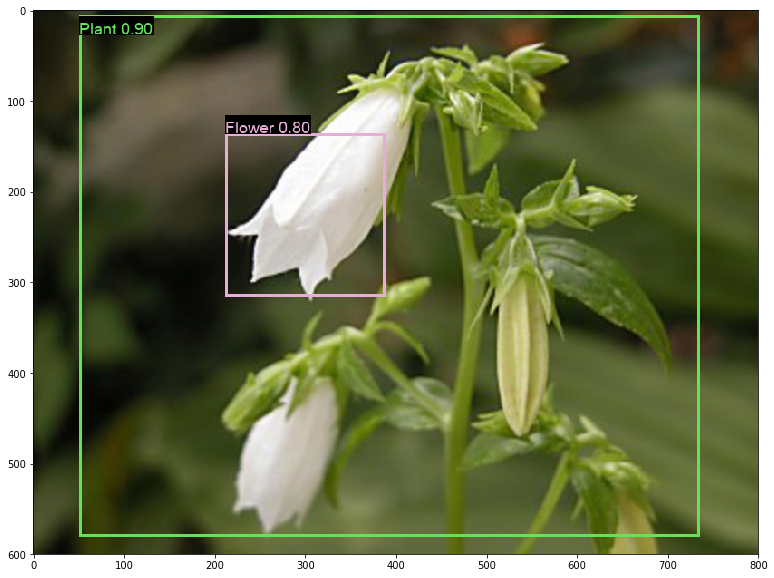

In [10]:
with torch.no_grad():
    result =  net.detect("./test_im/1036.jpg", thr=0.6)
    if result:
        pred_boxes, scores, classes, rois, im_data = result
        if(len(pred_boxes)):
            result_show(im_data[0], pred_boxes, classes, scores)

In [20]:
torch.save(net.rpn.state_dict(), './transfer_parameters/rpn_flower.pkl') 

In [21]:
torch.save(net.fc6.state_dict(), './transfer_parameters/fc6_flower.pkl')

In [22]:
torch.save(net.fc7.state_dict(), './transfer_parameters/fc7_flower.pkl')

In [46]:
torch.save(net.bbox_fc.state_dict(), './checkpoints/bbox_fc_flower.pkl')

In [23]:
torch.save(net.state_dict(), './transfer_parameters/full_network.pkl')

In [12]:

torch.save(net.rpn.features.state_dict(), './transfer_parameters/vgg16.pkl') 